In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings, functools
warnings.filterwarnings('ignore')
import functools
from decimal import Decimal
import openpyxl
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

from src.parse import parse_data
from src.utils import conf_iterval, norm_pdf
from src.model import Cyton2Model

rc = {
	'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 16,
	'xtick.labelsize': 16, 'ytick.labelsize': 16,
	'figure.figsize': (8, 6),
	'axes.grid': False, 'grid.linestyle': ':', 'axes.grid.which': 'both',
	'axes.axisbelow': True, 'axes.titlepad': 0,
	'axes.spines.top': False, 'axes.spines.right': False,
	'axes.spines.left': True, 'axes.spines.bottom': True,
	'ytick.left': True, 'xtick.bottom': True,
	'lines.markersize': 4.5, 'lines.linewidth': 1.0,
	'errorbar.capsize': 2.5
}
sns.set_theme(context='paper', style='white', rc=rc)

# Functions

## Linear addition of timers

In [2]:
# Define a function to perform signal addition by linear operation
# 1. Handles point estimates
# 2. Generate curves for CIs
def computeContribs(base, signal):
	"""Function to calculate contribution of a signal w.r.t the base
	base   : Control = No drug
	signal : Treatment = Rapa, MPA, CsA
	"""
	meds = ['mDiv0', 'mDD', 'mDie', 'b', '1-pl']
	sigs = ['sDiv0', 'sDD', 'sDie']

	contrib = {}  # Delta timers
	for med in meds:
		contrib[med] = signal[med] - base[med]
	for sig in sigs:
		contrib[sig] = signal[sig]**2 - base[sig]**2  # NB: storing as variance, NOT std => allowing reduction in variance

	return contrib

def signalAdd(base, contrib1, contrib2):
	# Add contributions from two drugs on the base signal
	meds = ['mDiv0', 'mDD', 'mDie', 'b', '1-pl']
	sigs = ['sDiv0', 'sDD', 'sDie']
	newPars = {}
	for med in meds:
		newPars[med] = base[med] + contrib1[med] + contrib2[med]
	for sig in sigs:
		newPars[sig] = np.sqrt(base[sig]**2 + contrib1[sig] + contrib2[sig])  # We pass std for base signal
	return newPars

def signalAddError(base, signal1, signal2):
	coll = []
	for (_, baseSig), (_, sig1), (_, sig2) in zip(base.iterrows(), signal1.iterrows(), signal2.iterrows()):
		conSig1 = computeContribs(baseSig, sig1)
		conSig2 = computeContribs(baseSig, sig2)

		combined = signalAdd(baseSig, conSig1, conSig2)
		coll.append(combined)
	return coll

def predict(df, icnd, predPars, predBoot, combBoot):
	hts = df['reader'].harvested_times[icnd]
	mgens = df['reader'].generation_per_condition[icnd]
	t0, tf, dt = 0, max(hts)+5, 0.1
	times = np.linspace(t0, tf, num=int(tf/dt)+1)

	N0 = df['cells']['avg'][icnd][0]  # Average total cell numbers at 0h
	N1 = N0 * predPars['1-pl']
	model = Cyton2Model(hts, N1, mgens, dt, [], logn=False)
	ext = model.extrapolate(times, predPars)

	_ext_cells_gen = []
	_hts_cells_gen = []
	curvesCI = {
		'f_tdiv0': [], 'f_tdd': [], 'f_tdie': [],
		'tdiv0': [], 'tdd': [], 'tdie': [],
		'ext_total_cells': [], 'ext_cells_gen': [],
		'hts_total_cells': [], 'hts_cells_gen': [],
		'mDiv0': [], 'sDiv0': [],
		'mDD': [], 'sDD': [],
		'mDie': [], 'sDie': [],
		'b': []
	}
	for (_, pPars), (_, comb) in zip(predBoot.iterrows(), combBoot.iterrows()):
		b_N1 = comb['N0'] * pPars['1-pl']  # N1 is measured cell numbers * actv. frac. of the control
		b_model = Cyton2Model(hts, b_N1, mgens, dt, [], logn=False)
		b_ext = b_model.extrapolate(times, pPars)

		f_tdiv0 = norm_pdf(times, comb['mDiv0'], comb['sDiv0'])
		f_tdd = norm_pdf(times, comb['mDD'], comb['sDD'])
		f_tdie = norm_pdf(times, comb['mDie'], comb['sDie'])
		curvesCI['f_tdiv0'].append(f_tdiv0)
		curvesCI['f_tdd'].append(f_tdd)
		curvesCI['f_tdie'].append(f_tdie)

		curvesCI['mDiv0'].append(pPars['mDiv0']); curvesCI['sDiv0'].append(pPars['sDiv0'])
		curvesCI['mDD'].append(pPars['mDD']); curvesCI['sDD'].append(pPars['sDD'])
		curvesCI['mDie'].append(pPars['mDie']); curvesCI['sDie'].append(pPars['sDie'])
		
		b_tdiv0 = norm_pdf(times, pPars['mDiv0'], pPars['sDiv0'])
		b_tdd = norm_pdf(times, pPars['mDD'], pPars['sDD'])
		b_tdie = norm_pdf(times, pPars['mDie'], pPars['sDie'])
		curvesCI['tdiv0'].append(b_tdiv0)
		curvesCI['tdd'].append(b_tdd)
		curvesCI['tdie'].append(b_tdie)

		curvesCI['ext_total_cells'].append(b_ext['ext']['total_live_cells'])
		_ext_cells_gen.append(b_ext['ext']['cells_gen'])
		curvesCI['ext_cells_gen'].append(_ext_cells_gen)
		curvesCI['hts_total_cells'].append(b_ext['hts']['total_live_cells'])
		_hts_cells_gen.append(b_ext['hts']['cells_gen'])
		curvesCI['hts_cells_gen'].append(_hts_cells_gen)
		curvesCI['b'].append(pPars['b'])
	# Calculate 95% confidence bands
	for obj in curvesCI:
		stack = np.vstack(curvesCI[obj])
		curvesCI[obj] = conf_iterval(stack, rgs=95)
	return times, ext, curvesCI

## Check predictions

In [3]:
def check_prediction(df, icnd, times, fittedPars, fittedBoot, predPars, predBoot, curvesCI, ext, path):
	## PDFs (Fitted? vs Predicted)
	fig1, ax1 = plt.subplots(tight_layout=True)
	# ax1.plot([], [], 'k--', label="Fitted")
	# ax1.plot(times, norm_pdf(times, fittedPars['mDiv0'], fittedPars['sDiv0']), 'b--')
	# ax1.fill_between(times, curvesCI['f_tdiv0'][0], curvesCI['f_tdiv0'][1], color='darkblue', alpha=0.3)
	# ax1.plot(times, norm_pdf(times, fittedPars['mDD'], fittedPars['sDD']), 'g--')
	# ax1.fill_between(times, curvesCI['f_tdd'][0], curvesCI['f_tdd'][1], color='darkgreen', alpha=0.3)
	# ax1.plot(times, -norm_pdf(times, fittedPars['mDie'], fittedPars['sDie']), 'r--')
	# ax1.fill_between(times, -curvesCI['f_tdie'][0], -curvesCI['f_tdie'][1], color='darkred', alpha=0.3)

	mDiv0, mDiv0_low, mDiv0_upp = predPars['mDiv0'].values[0], curvesCI['mDiv0'][0][0], curvesCI['mDiv0'][1][0]
	sDiv0, sDiv0_low, sDiv0_upp = predPars['sDiv0'].values[0], curvesCI['sDiv0'][0][0], curvesCI['sDiv0'][1][0]
	label_Tdiv0 = f"$T_{{div}}^0 \sim \mathcal{{N}}({mDiv0:.2f}\pm_{{{mDiv0-mDiv0_low:.2f}}}^{{{mDiv0_upp-mDiv0:.2f}}}, {sDiv0:.3f} \pm_{{{sDiv0-sDiv0_low:.3f}}}^{{{sDiv0_upp-sDiv0:.3f}}})$"
	tdiv0 = norm_pdf(times, mDiv0, sDiv0)
	mDD, mDD_low, mDD_upp = predPars['mDD'].values[0], curvesCI['mDD'][0][0], curvesCI['mDD'][1][0]
	sDD, sDD_low, sDD_upp = predPars['sDD'].values[0], curvesCI['sDD'][0][0], curvesCI['sDD'][1][0]
	label_Tdd = f"$T_{{dd}} \sim \mathcal{{N}}({mDD:.2f}\pm_{{{mDD-mDD_low:.2f}}}^{{{mDD_upp-mDD:.2f}}}, {sDD:.3f}\pm_{{{sDD-sDD_low:.3f}}}^{{{sDD_upp-sDD:.3f}}})$"
	tdd = norm_pdf(times, mDD, sDD)
	mDie, mDie_low, mDie_upp = predPars['mDie'].values[0], curvesCI['mDie'][0][0], curvesCI['mDie'][1][0]
	sDie, sDie_low, sDie_upp = predPars['sDie'].values[0], curvesCI['sDie'][0][0], curvesCI['sDie'][1][0]
	label_Tdie = f"$T_{{die}} \sim \mathcal{{N}}({mDie:.2f}\pm_{{{mDie-mDie_low:.2f}}}^{{{mDie_upp-mDie:.2f}}}, {sDie:.3f}\pm_{{{sDie-sDie_low:.3f}}}^{{{sDie_upp-sDie:.3f}}})$"
	tdie = norm_pdf(times, mDie, sDie)
	# ax1.plot([], [], 'k-', label="Predicted")
	b, b_low, b_upp = predPars['b'].values[0], curvesCI['b'][0][0], curvesCI['b'][1][0]
	ax1.annotate(f"$b = {b:.2f}\pm_{{{b-b_low:.2f}}}^{{{b_upp-b:.2f}}}h$", xy=(0.01, 0.95), xycoords='axes fraction', color='navy')
	ax1.plot(times, tdiv0, 'b-', label=label_Tdiv0)
	ax1.fill_between(times, curvesCI['tdiv0'][0], curvesCI['tdiv0'][1], fc='b', ec=None, alpha=0.3)
	ax1.plot(times, tdd, 'g-', label=label_Tdd)
	ax1.fill_between(times, curvesCI['tdd'][0], curvesCI['tdd'][1], fc='g', ec=None, alpha=0.3)
	ax1.plot(times, -tdie, 'r-', label=label_Tdie)
	ax1.fill_between(times, -curvesCI['tdie'][0], -curvesCI['tdie'][1], fc='r', ec=None, alpha=0.3)
	ax1.set(xlim=[0,max(times)], xlabel="Time (hour)", ylabel="Density")
	ax1.legend(fontsize=12)
	ax1.set_yticks(ax1.get_yticks())
	ax1.set_yticklabels(np.round(np.abs(ax1.get_yticks()), 5))  # remove negative y-tick labels

	## Total cells (incl. cells per generation vs time)
	fig2, ax2 = plt.subplots(tight_layout=True)
	hts = df['reader'].harvested_times[icnd]
	mgens = df['reader'].generation_per_condition[icnd]
	cells = df['cells']['avg'][icnd]
	cells_sem = df['cells']['sem'][icnd]
	ax2.errorbar(hts, cells, yerr=cells_sem, fmt='ko', mfc='none', mec='k', label="Total")
	ax2.plot(times, ext['ext']['total_live_cells'], 'k-', label="Model")
	ax2.fill_between(times, curvesCI['ext_total_cells'][0], curvesCI['ext_total_cells'][1], fc='k', ec=None, alpha=0.3)
	cp = sns.hls_palette(mgens+1, l=0.4, s=0.5)
	for igen in range(0, mgens+1):
		ax2.errorbar(hts, np.transpose(df['cgens']['avg'][icnd])[igen], yerr=np.transpose(df['cgens']['sem'][icnd])[igen], c=cp[igen], fmt='o', ms=5, label=f"Gen {igen}")
		ax2.plot(times, ext['ext']['cells_gen'][igen], c=cp[igen])
		ax2.fill_between(times, curvesCI['ext_cells_gen'][0][igen], curvesCI['ext_cells_gen'][1][igen], fc=cp[igen], ec=None, alpha=0.3)
	ax2.legend(fontsize=12)
	ax2.set(xlim=[0,max(times)], ylim=[0,None], xlabel="Time (hour)", ylabel="Cell number")
	ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
	ax2.yaxis.major.formatter._useMathText = True

	## Cells per generation
	fig3 = plt.figure(figsize=(8,7))
	gens = np.array([i for i in range(mgens+1)])
	fig3.text(0.5, 0.04, "Generations", ha='center', va='center')
	fig3.text(0.02, 0.5, "Cell number", ha='center', va='center', rotation=90)
	axes = []  # store axis
	for itpt, ht in enumerate(hts):
		ax3 = plt.subplot(3, 3, itpt+1)
		ax3.set_axisbelow(True)
		ax3.errorbar(gens, df['cgens']['avg'][icnd][itpt], yerr=df['cgens']['sem'][icnd][itpt], fmt='ro', label='Data')
		ax3.plot(gens, ext['hts']['cells_gen'][itpt], 'o-', c='k', ms=5, label='Model')
		ax3.fill_between(gens, curvesCI['hts_cells_gen'][0][itpt], curvesCI['hts_cells_gen'][1][itpt], fc='k', ec=None, alpha=0.3)
		ax3.set_xticks(gens)
		ax3.annotate(f"{ht}h", xy=(0.75, 0.85), xycoords='axes fraction')
		ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
		ax3.yaxis.major.formatter._useMathText = True
		if itpt not in [len(hts)-3, len(hts)-2, len(hts)-1]:
			ax3.set_xticklabels([])
		if itpt not in [0, 3, 6, 9, 12]:
			ax3.set_yticklabels([])
		ax3.spines['right'].set_visible(True)
		ax3.spines['top'].set_visible(True)
		ax3.grid(True, ls='--')
		axes.append(ax3)
	max_ylim = 0
	for ax in axes:
		_, ymax = ax.get_ylim()
		if max_ylim < ymax:
			max_ylim = ymax
	for ax in axes:
		ax.set_ylim(top=max_ylim)
	handles, labels = [], []
	for ax in fig3.axes:
		hs, ls = ax.get_legend_handles_labels()
		for h, l in zip(hs, ls):
			if l not in labels:
				handles.append(h)
				labels.append(l)
	fig3.legend(handles=handles, labels=labels, fontsize=12, ncol=3, bbox_to_anchor=(1,1))
	fig3.tight_layout(rect=(0.02, 0.03, 1, 1))
	fig3.subplots_adjust(wspace=0.05, hspace=0.2)

	## Quantifying predictive power
	# Data vs Model (linear relation b/w data and predicted total cell numbers)
	x1 = np.array(df['cells']['avg'][icnd])
	x1_sem = np.array(df['cells']['sem'][icnd])
	y1 = np.array(ext['hts']['total_live_cells'])
	tcell_max = max(np.concatenate([x1, y1]))
	y_eq_x = np.linspace(0, tcell_max, num=10000)

	fig4, ax4 = plt.subplots(tight_layout=True)
	ax4.plot(y_eq_x, y_eq_x, 'k--')
	ax4.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, width=0.004)
	for i, (x, y) in enumerate(zip(x1, y1)):
		ylow95 = y - curvesCI['hts_total_cells'][0][i]
		yupp95 = curvesCI['hts_total_cells'][1][i] - y
		if ylow95 < 0:
			ylow95 = 0
		if yupp95 < 0:
			yupp95 = 0
		ax4.errorbar(x, y, xerr=x1_sem[i], yerr=[[ylow95], [yupp95]], fmt='o', ms=6, mec='k', label=f"{hts[i]}h", zorder=10, clip_on=False)
	ax4.legend(fontsize=12, handletextpad=0.1)
	ax4.set(xlabel="Measured total cell number", ylabel="Predicted total cell number", xlim=[0,None], ylim=[0,None])
	ax4.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
	ax4.xaxis.major.formatter._useMathText = True
	ax4.yaxis.major.formatter._useMathText = True

	rho = sps.pearsonr(x1, y1)
	ax4.annotate(r"Pearson's $r$", xy=(0.13, 0.95), xycoords='axes fraction', fontsize=14)
	ax4.annotate(rf"$r = {rho.statistic:.3f}$ ($p$ = {rho.pvalue:.5f})", xy=(0.13, 0.9), xycoords='axes fraction', fontsize=14)

	# Root-mean-squared-error
	def rmse(data, model):
		RSS = np.sum((data - model)**2)  # residual sum-of-squares
		MSE = RSS / len(data)			  # mean-squared-error
		RMSE = np.sqrt(MSE)			  # root-mean-squared-error
		return RMSE
	
	data = np.array(df['cgens']['rep'][icnd], dtype=object)
	# data_flat = data.ravel()
	reps = [len(l) for l in data]
	data_flat = [cell for time_data in data for cell_data in time_data for cell in cell_data]  # In case ravel doesn't work...

	# RMSE of fitted (+bootstrap)
	N0 = df['cells']['avg'][icnd][0]
	f_N1 = N0 * fittedPars['1-pl']
	f_model = Cyton2Model(hts, f_N1, mgens, 0.1, reps, logn=False)
	f_eval = f_model.evaluate(
		fittedPars['mDiv0'], fittedPars['sDiv0'],
		fittedPars['mDD'], fittedPars['sDD'],
		fittedPars['mDie'], fittedPars['sDie'],
		fittedPars['b']
	)
	f_rmse = rmse(data_flat, f_eval)
	fb_rmse = []
	for _, f_boot in fittedBoot.iterrows():
		f_pars = fittedPars.copy()
		f_pars['mDiv0'], f_pars['sDiv0'] = f_boot['mDiv0'], f_boot['sDiv0']
		f_pars['mDD'], f_pars['sDD'] = f_boot['mDD'], f_boot['sDD']
		f_pars['mDie'], f_pars['sDie'] = f_boot['mDie'], f_boot['sDie']
		f_pars['b'] = f_boot['b']
		
		fb_N1 = f_boot['N0'] * f_boot['1-pl']
		fb_model = Cyton2Model(hts, fb_N1, mgens, 0.1, reps, logn=False)
		fb_eval = fb_model.evaluate(
			f_pars['mDiv0'], f_pars['sDiv0'],
			f_pars['mDD'], f_pars['sDD'],
			f_pars['mDie'], f_pars['sDie'],
			f_pars['b']
		)
		fb_rmse.append(rmse(data_flat, fb_eval))
	
	# RMSE of predicted (+bootstrap)
	p_N1 = N0 * predPars['1-pl']
	p_model = Cyton2Model(hts, p_N1, mgens, 0.1, reps, logn=False)
	p_eval = p_model.evaluate(
		predPars['mDiv0'], predPars['sDiv0'],
		predPars['mDD'], predPars['sDD'],
		predPars['mDie'], predPars['sDie'],
		predPars['b']
	)
	p_rmse = rmse(data_flat, p_eval)
	pb_rmse = []
	for (_, p_boot), (_, f_boot) in zip(predBoot.iterrows(), fittedBoot.iterrows()):
		p_pars = predPars.copy()
		p_pars['mDiv0'], p_pars['sDiv0'] = p_boot['mDiv0'], p_boot['sDiv0']
		p_pars['mDD'], p_pars['sDD'] = p_boot['mDD'], p_boot['sDD']
		p_pars['mDie'], p_pars['sDie'] = p_boot['mDie'], p_boot['sDie']
		p_pars['b'] = p_boot['b']

		pb_N1 = f_boot['N0'] * p_boot['1-pl']
		pb_model = Cyton2Model(hts, pb_N1, mgens, 0.1, reps, logn=False)
		pb_eval = pb_model.evaluate(
			p_pars['mDiv0'], p_pars['sDiv0'],
			p_pars['mDD'], p_pars['sDD'],
			p_pars['mDie'], p_pars['sDie'],
			p_pars['b']
		)
		pb_rmse.append(rmse(data_flat, pb_eval))
	
	fig5, ax5 = plt.subplots(tight_layout=True)
	ax5.axhline(f_rmse, color='b', ls='--')
	ax5.axhline(p_rmse, color='r', ls='--')
	sns.violinplot([fb_rmse, pb_rmse], palette=['b', 'r'], ax=ax5)
	ax5.set_xticklabels(['Fitted', 'Predicted'])
	ax5.set(ylabel="RMSE", ylim=[0,None])

	save_to_excel(times, tdiv0, tdd, tdie, ext, curvesCI, hts, mgens, gens, x1, x1_sem, y1, f_rmse, fb_rmse, p_rmse, pb_rmse, path)

	return fig1, fig2, fig3, fig4, fig5


def save_to_excel(times, tdiv0, tdd, tdie, ext, CI, hts, mgen, gens, x, x_sem, y, f_rmse, fb_rmse, p_rmse, pb_rmse, path):
	def auto_adjust_xlsx_column_width(df, writer, sheet_name, margin=0, length_factor=1.0, decimals=3, index=False):
		def text_length(text):
			"""
			Get the effective text length in characters, taking into account newlines
			"""
			if not text:
				return 0
			lines = text.split("\n")
			return max(len(line) for line in lines)

		def _to_str_for_length(v, decimals=3):
			"""
			Like str() but rounds decimals to predefined length
			"""
			if isinstance(v, float):
				# Round to [decimal] places
				return str(Decimal(v).quantize(Decimal('1.' + '0' * decimals)).normalize())
			else:
				return str(v)
		
		sheet = writer.sheets[sheet_name]
		_to_str = functools.partial(_to_str_for_length, decimals=decimals)
		# Compute & set column width for each column
		for column_name in df.columns:
			# Convert the value of the columns to string and select the 
			column_length =  max(df[column_name].apply(_to_str).map(text_length).max(), text_length(column_name)) + 5
			# Get index of column in XLSX
			# Column index is +1 if we also export the index column
			col_idx = df.columns.get_loc(column_name)
			if index:
				col_idx += 1
			# Set width of column to (column_length + margin)
			sheet.column_dimensions[openpyxl.utils.cell.get_column_letter(col_idx+1)].width = column_length * length_factor + margin
		# Compute column width of index column (if enabled)
		if index: # If the index column is being exported
			index_length =  max(df.index.map(_to_str).map(text_length).max(), text_length(df.index.name))
			sheet.column_dimensions["A"].width = index_length * length_factor + margin
	
	predPDFs = pd.DataFrame({
		'Time (hour)': times,
		'Tdiv0': tdiv0,
		'Tdiv0 (low95)': CI['tdiv0'][0],
		'Tdiv0 (upp95)': CI['tdiv0'][1],
		'Tdd': tdd,
		'Tdd (low95)': CI['tdd'][0],
		'Tdd (upp95)': CI['tdd'][1],
		'Tdie': tdie,
		'Tdie (low95)': CI['tdie'][0],
		'Tdie (upp95)': CI['tdie'][1],
	})
	cellsVStime = pd.DataFrame({
		'Time (hour)': times,
		'Total cells': ext['ext']['total_live_cells'],
		'Total cells (low95)': CI['ext_total_cells'][0],
		'Total cells (upp95)': CI['ext_total_cells'][1],
	})
	for igen in range(mgen+1):
		cellsVStime[f'Gen{igen}'] = ext['ext']['cells_gen'][igen]
		cellsVStime[f'Gen{igen} (low95)'] = CI['ext_cells_gen'][0][igen]
		cellsVStime[f'Gen{igen} (upp95)'] = CI['ext_cells_gen'][1][igen]
	
	cellsVSgen = pd.DataFrame({
		'Gens': gens
	})
	for itpt, ht in enumerate(hts):
		cellsVSgen[f'{ht}h'] = ext['hts']['cells_gen'][itpt]
		cellsVSgen[f'{ht}h (low95)'] = CI['hts_cells_gen'][0][itpt]
		cellsVSgen[f'{ht}h (upp95)'] = CI['hts_cells_gen'][1][itpt]

	predVSdata = pd.DataFrame({
		'Time points (hour)': hts,
		'Measured total cells': x,
		'Measured total cells (low SEM)': x - x_sem,
		'Measured total cells (upp SEM)': x + x_sem,
		'Predicted total cells': y,
		'Predicted total cells (low95)': CI['hts_total_cells'][0],
		'Predicted total cells (upp95)': CI['hts_total_cells'][1]
	})

	RMSE = pd.DataFrame({
		'Fitted (point est.)': f_rmse,
		'Fitted (bootstrap)': fb_rmse,
		'Predicted (point est.)' : p_rmse,
		'Predicted (bootstrap)': pb_rmse
	})

	ex_path = f"{path}/Model prediction.xlsx"
	with pd.ExcelWriter(ex_path, engine='openpyxl', mode='w') as writer:
		predPDFs.to_excel(writer, index=False, sheet_name="PDFs")
		cellsVStime.to_excel(writer, index=False, sheet_name="Cyton2 (Cells)")
		cellsVSgen.to_excel(writer, index=False, sheet_name="Cyton2 (CellsPerGen)")
		predVSdata.to_excel(writer, index=False, sheet_name="Model vs Data")
		RMSE.to_excel(writer, index=False, sheet_name="RMSE")
		wsRMSE = writer.sheets['RMSE']
		wsRMSE.merge_cells(start_row=2, start_column=1, end_row=len(fb_rmse)+1, end_column=1)
		wsRMSE.merge_cells(start_row=2, start_column=3, end_row=len(pb_rmse)+1, end_column=3)
		wsRMSE.cell(2, 1).alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
		wsRMSE.cell(2, 3).alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')

		auto_adjust_xlsx_column_width(predPDFs, writer, "PDFs")
		auto_adjust_xlsx_column_width(cellsVStime, writer, "Cyton2 (Cells)")
		auto_adjust_xlsx_column_width(cellsVSgen, writer, "Cyton2 (CellsPerGen)")
		auto_adjust_xlsx_column_width(predVSdata, writer, "Model vs Data")
		auto_adjust_xlsx_column_width(RMSE, writer, "RMSE")

# [DV24_003] Rapa + MPA

In [4]:
dfRAPA_MPA = parse_data('./data', ['DV24_003 Rapa+MPA.xlsx'])['DV24_003 Rapa+MPA']
dfRAPA_MPA['reader'].condition_names

['No drug',
 'Rapa 158pgmL',
 'Rapa 500pgmL',
 'MPA 50ngmL',
 'Rapa 158pgmL + MPA 50ngmL',
 'Rapa 500pgmL + MPA 50ngmL',
 'MPA 100ngmL',
 'Rapa 158pgmL + MPA 100ngmL',
 'Rapa 500pgmL + MPA 100ngmL',
 'unstimulated']

In [5]:
# Extract and define key variables
key = 'DV24_003 Rapa+MPA'
fitpath = './out/Best-fit Parameters/3. Same Timer/DV24_003 Rapa + MPA (Fixed Tdd)'

# Import No drug parameters
parsCTRL = pd.read_excel(f'{fitpath}/{key}_No drug_result.xlsx', sheet_name=f'pars_Nodrug', index_col=0)['best-fit'].to_dict()
bootCTRL = pd.read_excel(f'{fitpath}/{key}_No drug_result.xlsx', sheet_name=f'boot_Nodrug', index_col=0)

# Import MPA titrations
parsMPA50 = pd.read_excel(f'{fitpath}/{key}_MPA 50ngmL_result.xlsx', sheet_name=f'pars_MPA50ngmL', index_col=0)['best-fit'].to_dict()
bootMPA50 = pd.read_excel(f'{fitpath}/{key}_MPA 50ngmL_result.xlsx', sheet_name=f'boot_MPA50ngmL', index_col=0)

parsMPA100 = pd.read_excel(f'{fitpath}/{key}_MPA 100ngmL_result.xlsx', sheet_name=f'pars_MPA100ngmL', index_col=0)['best-fit'].to_dict()
bootMPA100 = pd.read_excel(f'{fitpath}/{key}_MPA 100ngmL_result.xlsx', sheet_name=f'boot_MPA100ngmL', index_col=0)

# Import RAPA titrations
parsRAPA158 = pd.read_excel(f'{fitpath}/{key}_Rapa 158pgmL_result.xlsx', sheet_name=f'pars_Rapa158pgmL', index_col=0)['best-fit'].to_dict()
bootRAPA158 = pd.read_excel(f'{fitpath}/{key}_Rapa 158pgmL_result.xlsx', sheet_name=f'boot_Rapa158pgmL', index_col=0)

parsRAPA500 = pd.read_excel(f'{fitpath}/{key}_Rapa 500pgmL_result.xlsx', sheet_name=f'pars_Rapa500pgmL', index_col=0)['best-fit'].to_dict()
bootRAPA500 = pd.read_excel(f'{fitpath}/{key}_Rapa 500pgmL_result.xlsx', sheet_name=f'boot_Rapa500pgmL', index_col=0)

## Rapa 158 + MPA 50

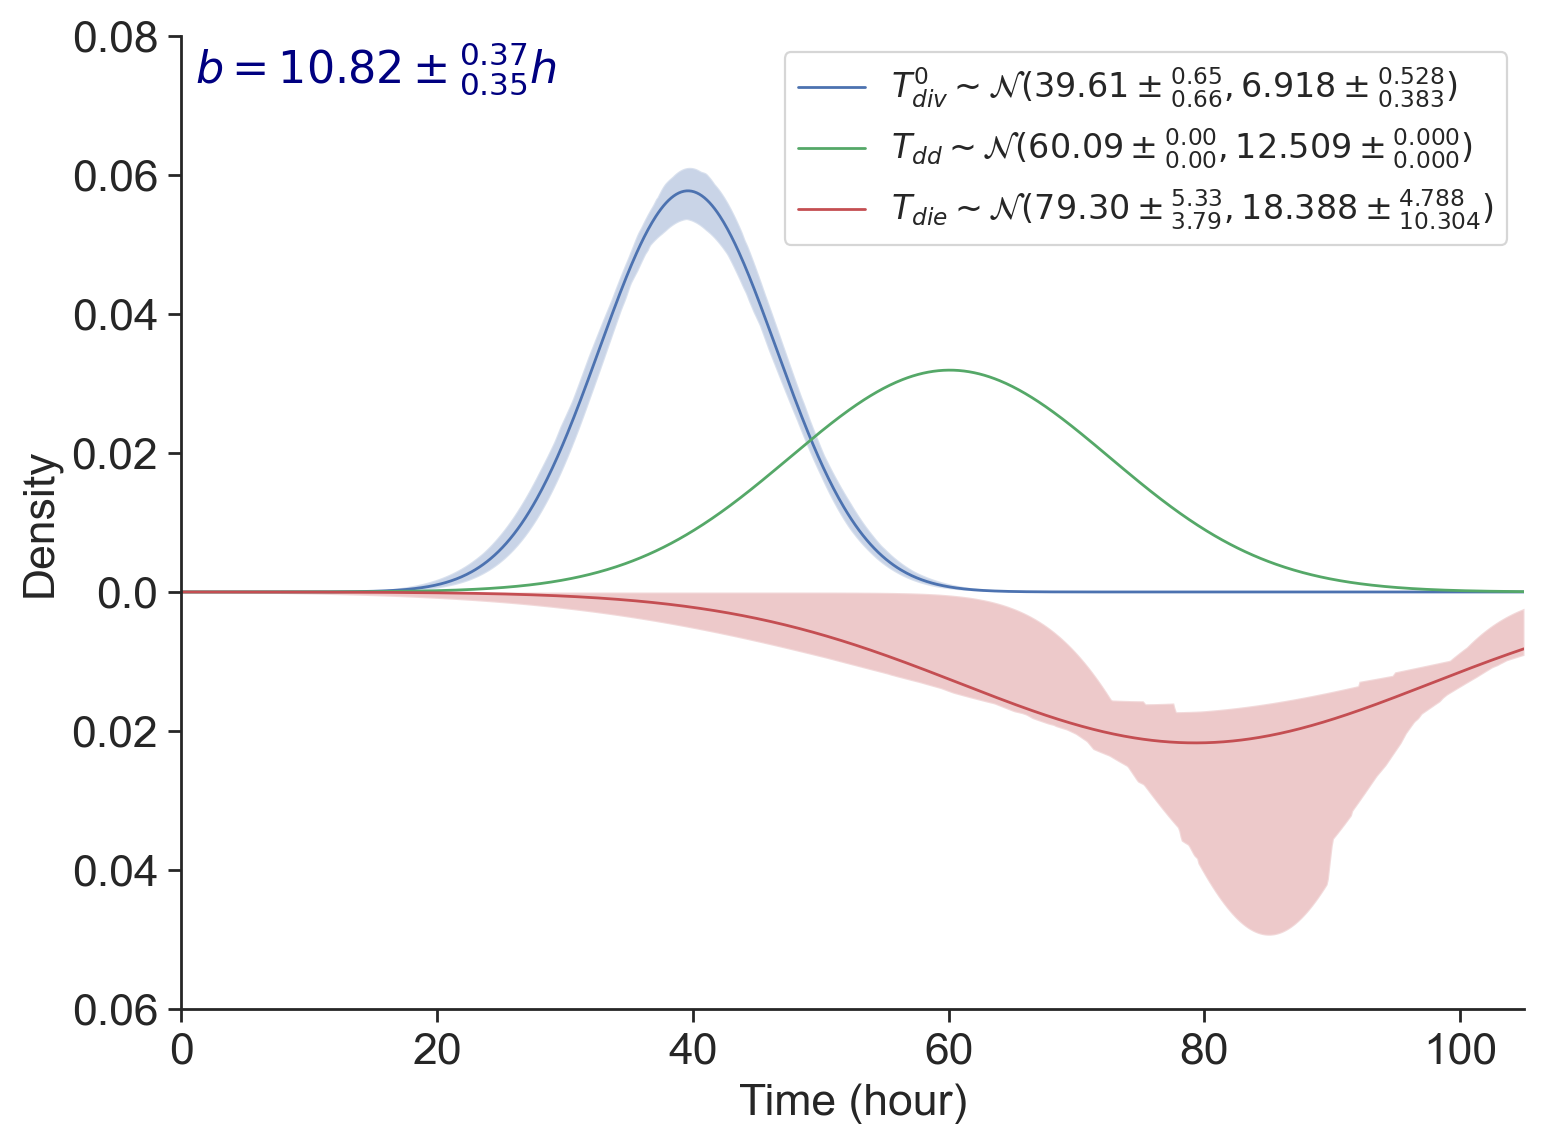

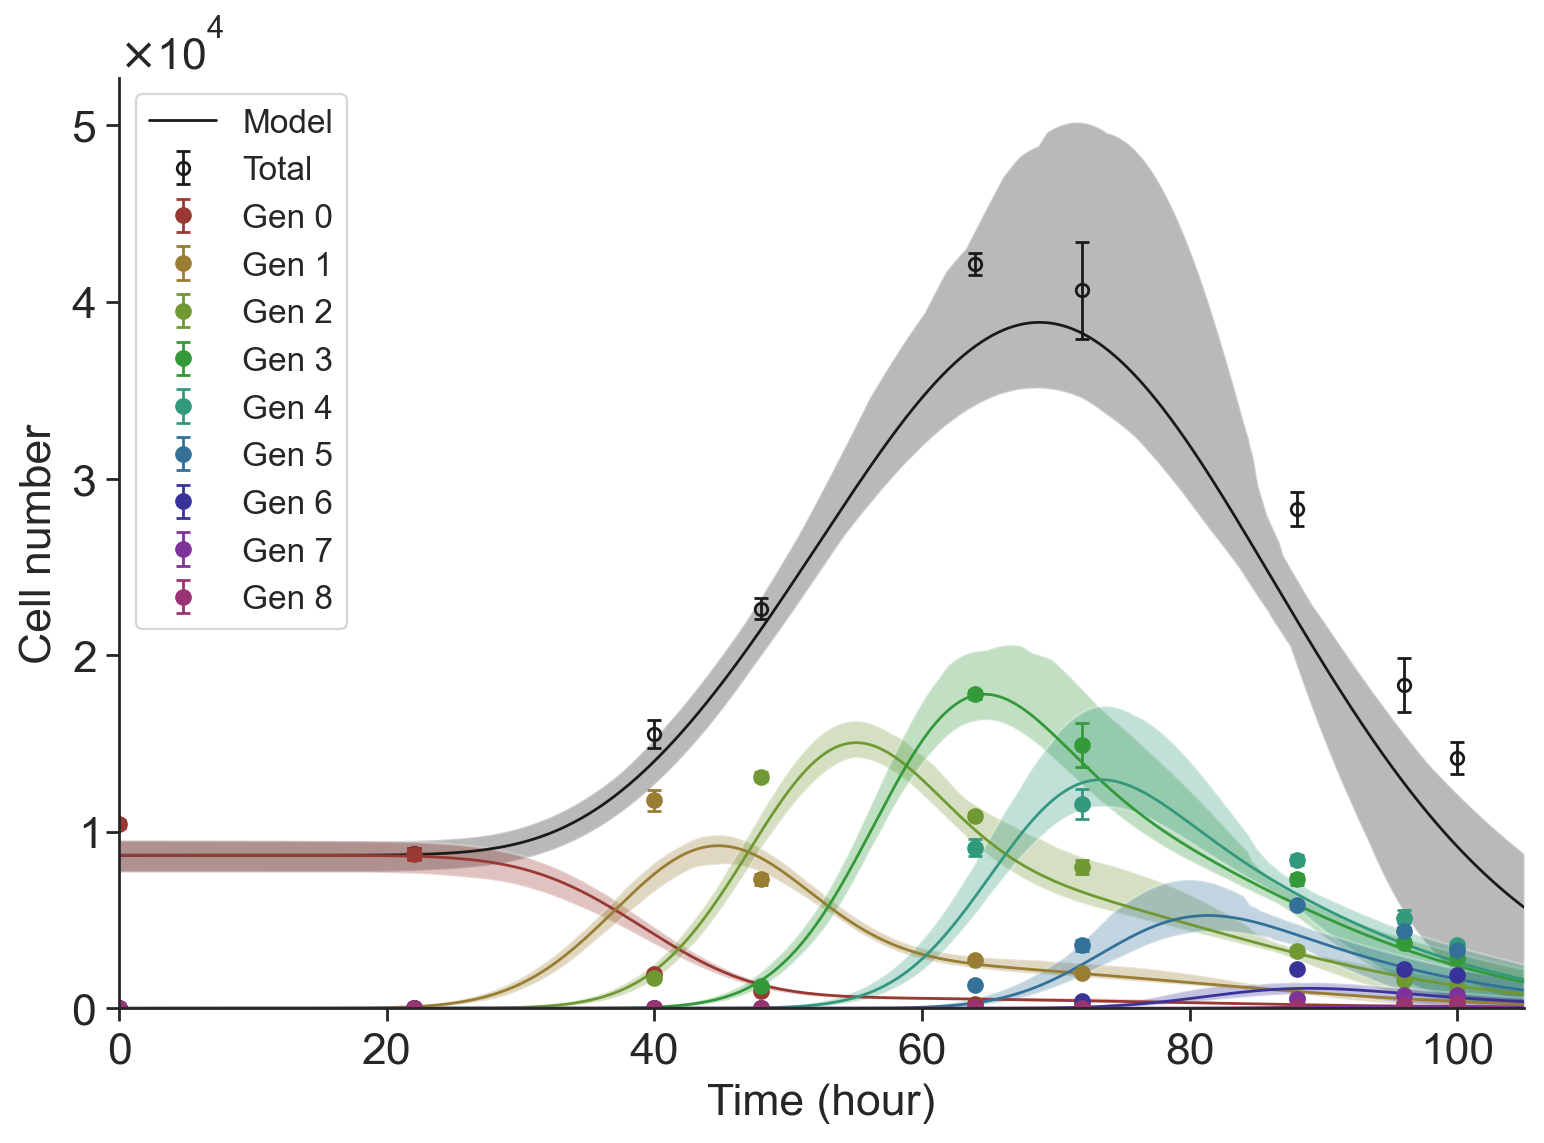

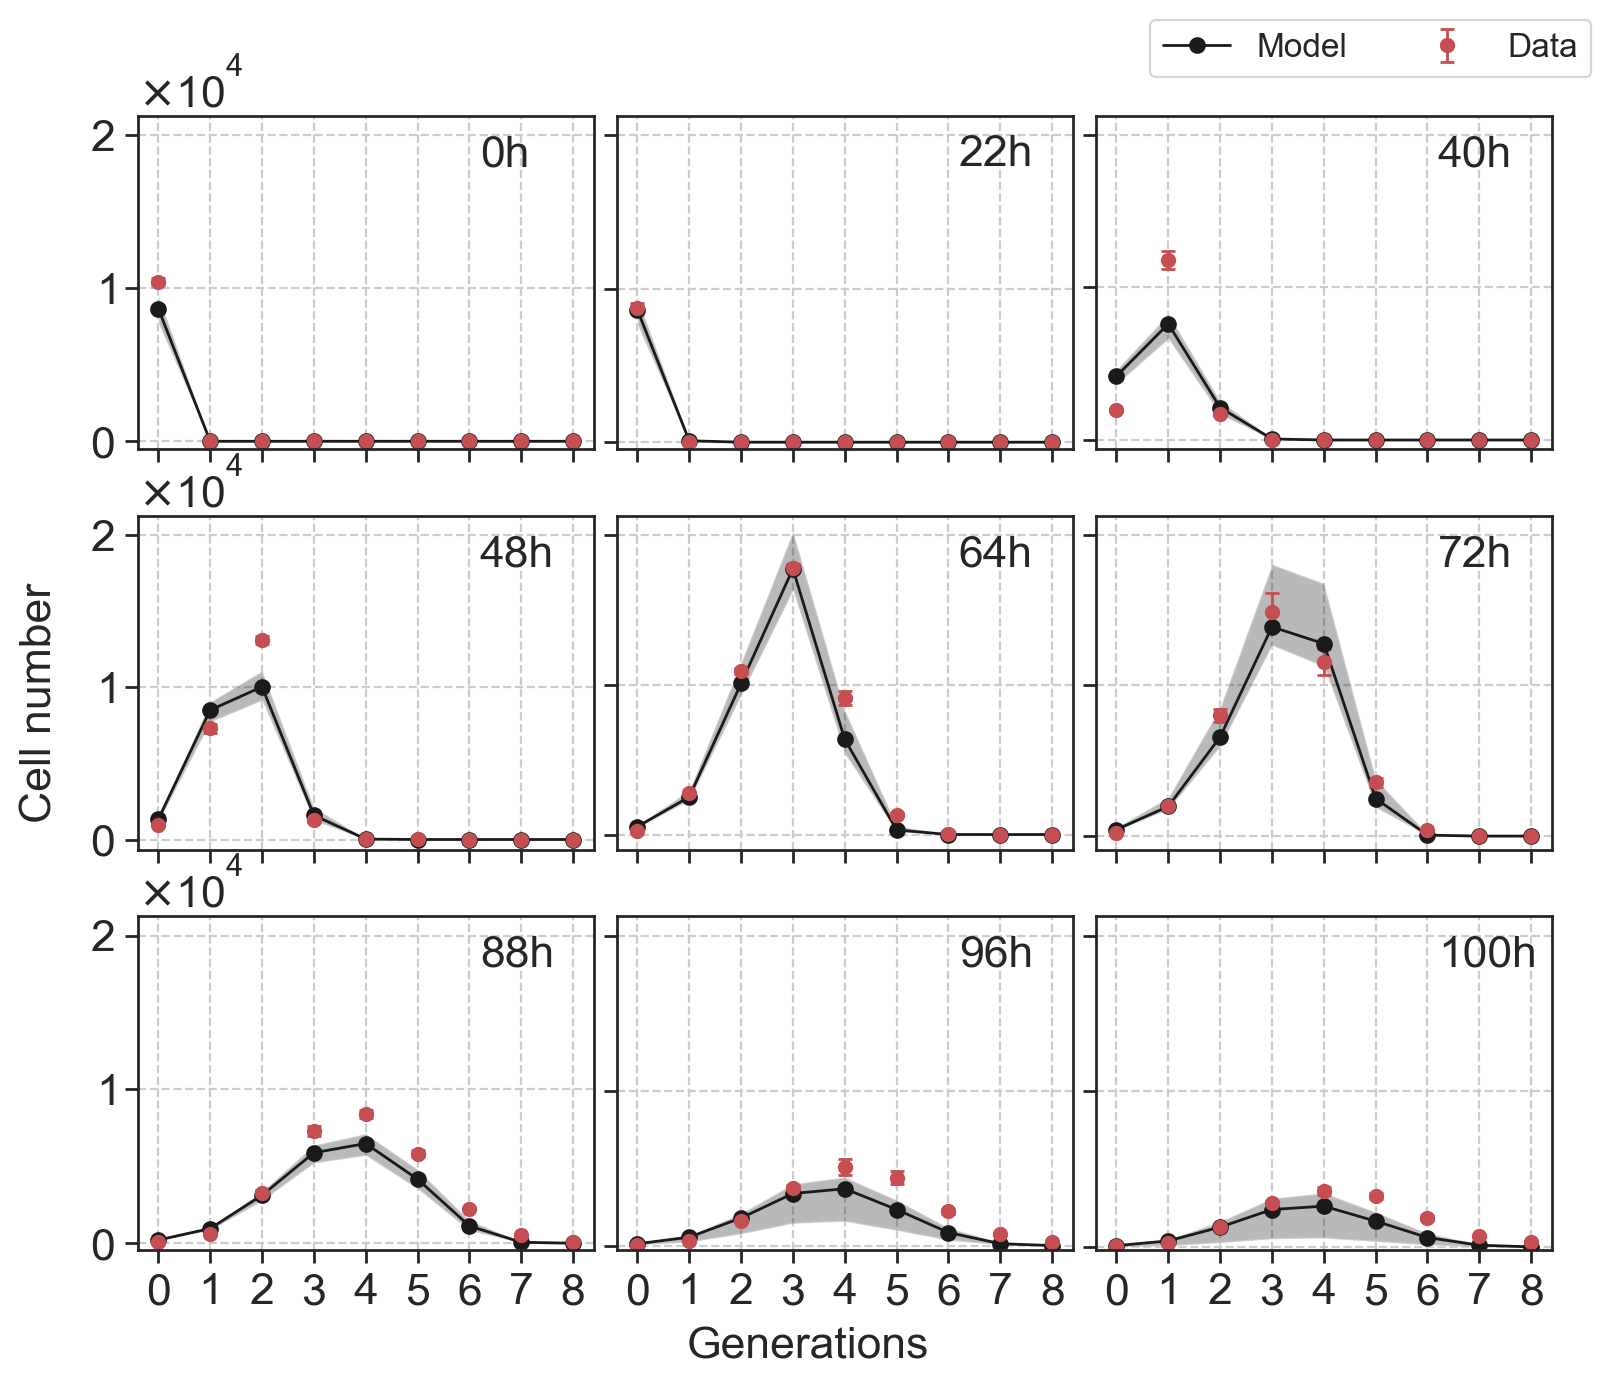

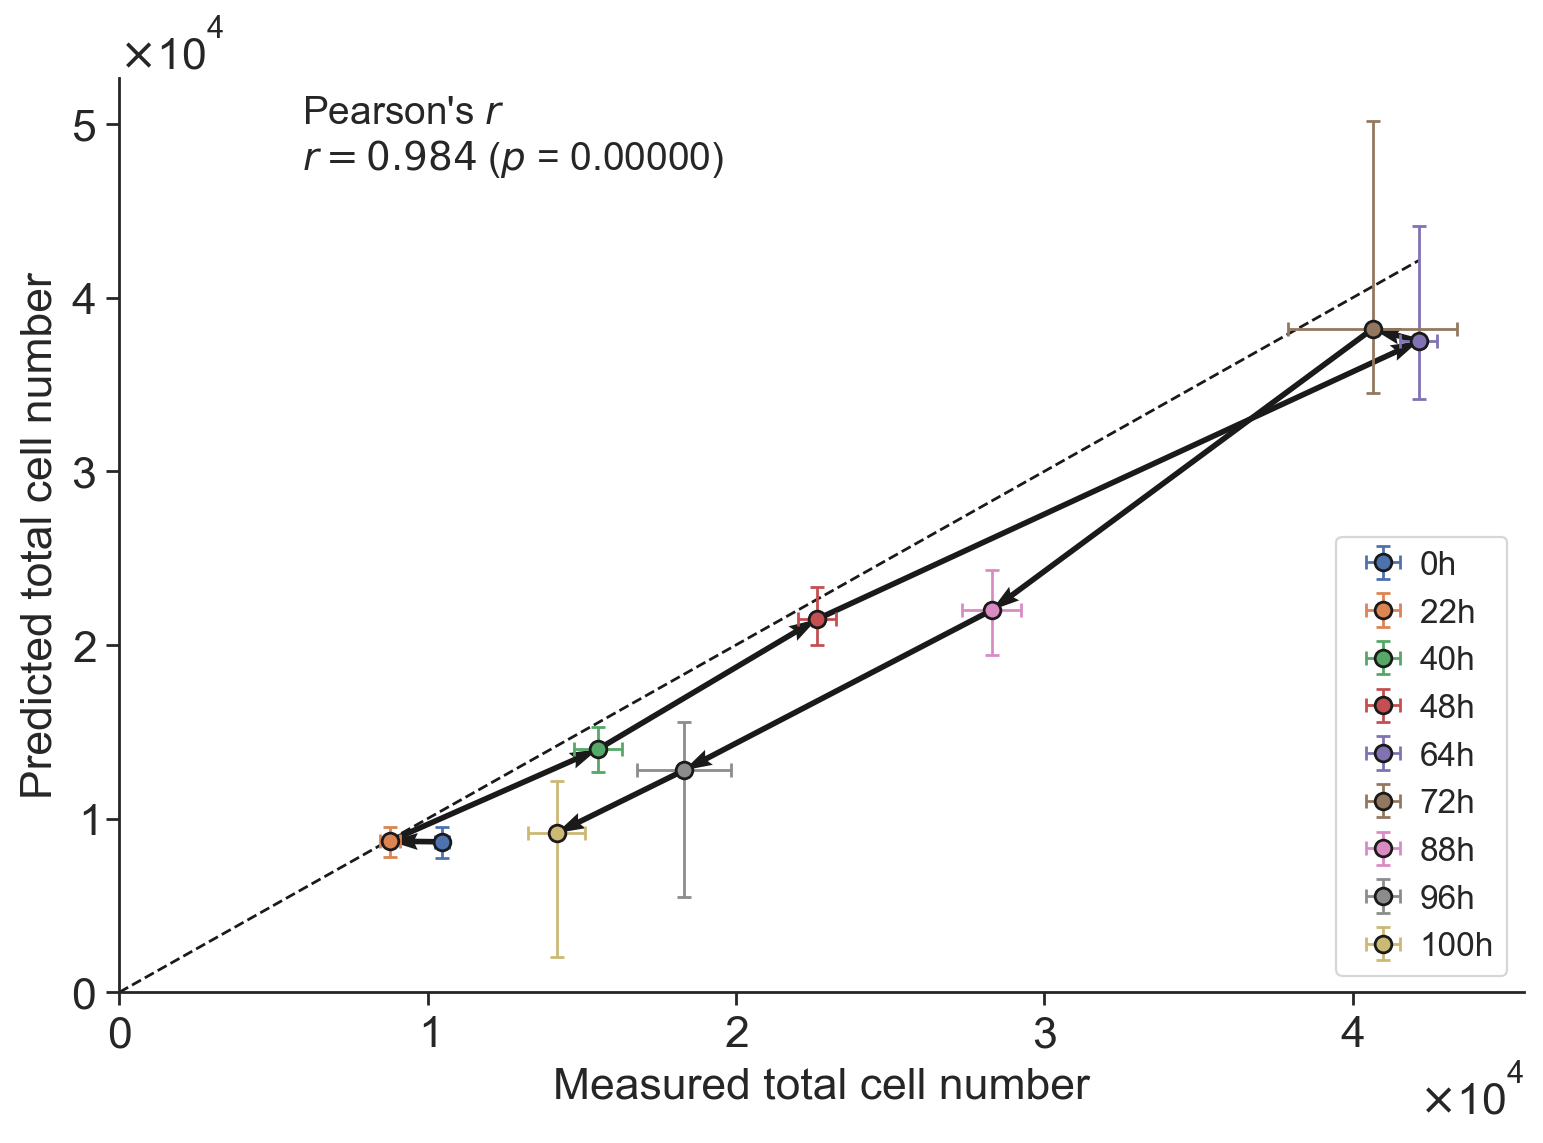

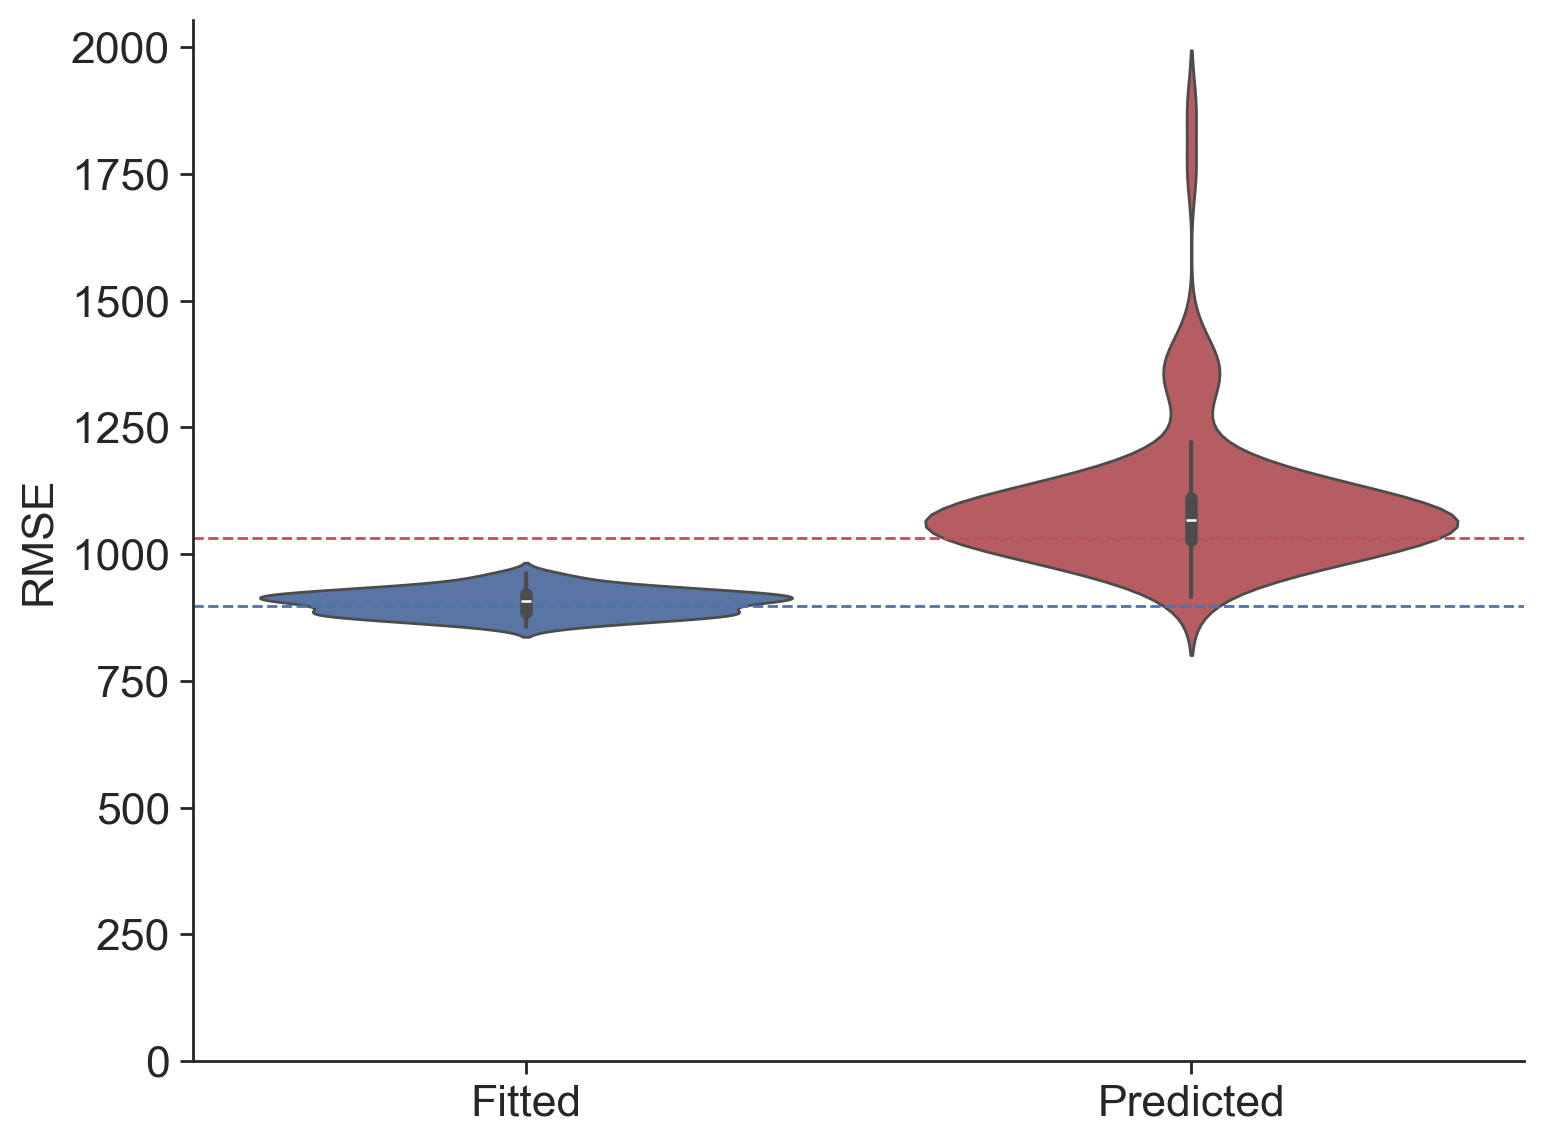

In [6]:
parsRAPA158MPA50 = pd.read_excel(f'{fitpath}/{key}_Rapa 158pgmL + MPA 50ngmL_result.xlsx', sheet_name=f'pars_Rapa158pgmL+MPA50ngmL', index_col=0)['best-fit'].to_dict()
fittedPars = parsRAPA158MPA50.copy() 
bootRAPA158MPA50 = pd.read_excel(f'{fitpath}/{key}_Rapa 158pgmL + MPA 50ngmL_result.xlsx', sheet_name=f'boot_Rapa158pgmL+MPA50ngmL', index_col=0)
fittedBoot = bootRAPA158MPA50.copy()

icnd = 4
contribRAPA158 = computeContribs(parsCTRL, parsRAPA158)
contribMPA50 = computeContribs(parsCTRL, parsMPA50)
predPars = pd.DataFrame([signalAdd(parsCTRL, contribRAPA158, contribMPA50)])
predBoot = pd.DataFrame(signalAddError(bootCTRL, bootRAPA158, bootMPA50))
# nan_cols = predBoot.columns[predBoot.isna().any()].tolist()
nan_idx = predBoot[predBoot.isnull().any(axis=1)].index
predBoot = predBoot.drop(nan_idx)
fittedBoot = fittedBoot.drop(nan_idx)
times, ext, curvesCI = predict(dfRAPA_MPA, icnd, predPars, predBoot, bootRAPA158MPA50)

path = "./out/Predictions/2. Same Timer/RAPA + MPA/DV24_003/RAPA 158 + MPA 50"
fig1, fig2, fig3, fig4, fig5 = check_prediction(dfRAPA_MPA, icnd, times, fittedPars, fittedBoot, predPars, predBoot, curvesCI, ext, path)
fig1.savefig(f"{path}/f1_predicted_PDFs.pdf", dpi=300)
fig2.savefig(f"{path}/f2_predicted_Cells.pdf", dpi=300)
fig3.savefig(f"{path}/f3_predicted_CellsGens.pdf", dpi=300)
fig4.savefig(f"{path}/f4_ModelvsData.pdf", dpi=300)
fig5.savefig(f"{path}/f5_RMSE.pdf", dpi=300)
plt.show()

## Rapa 158 + MPA 100

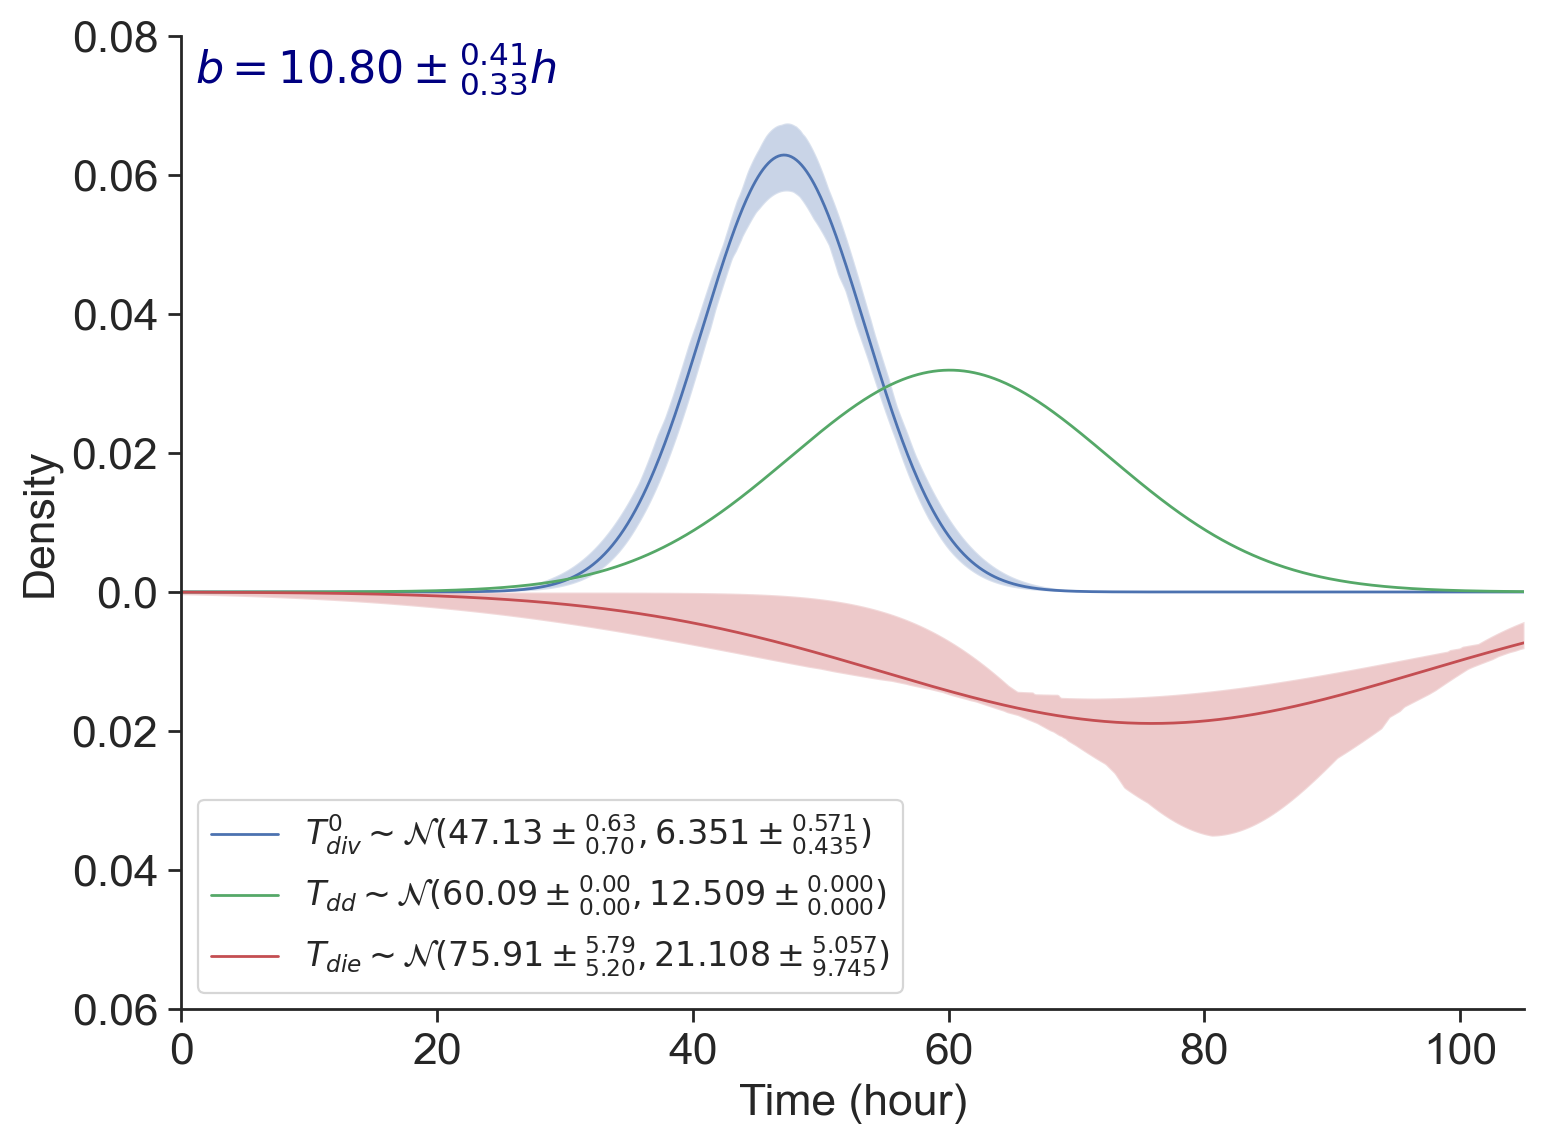

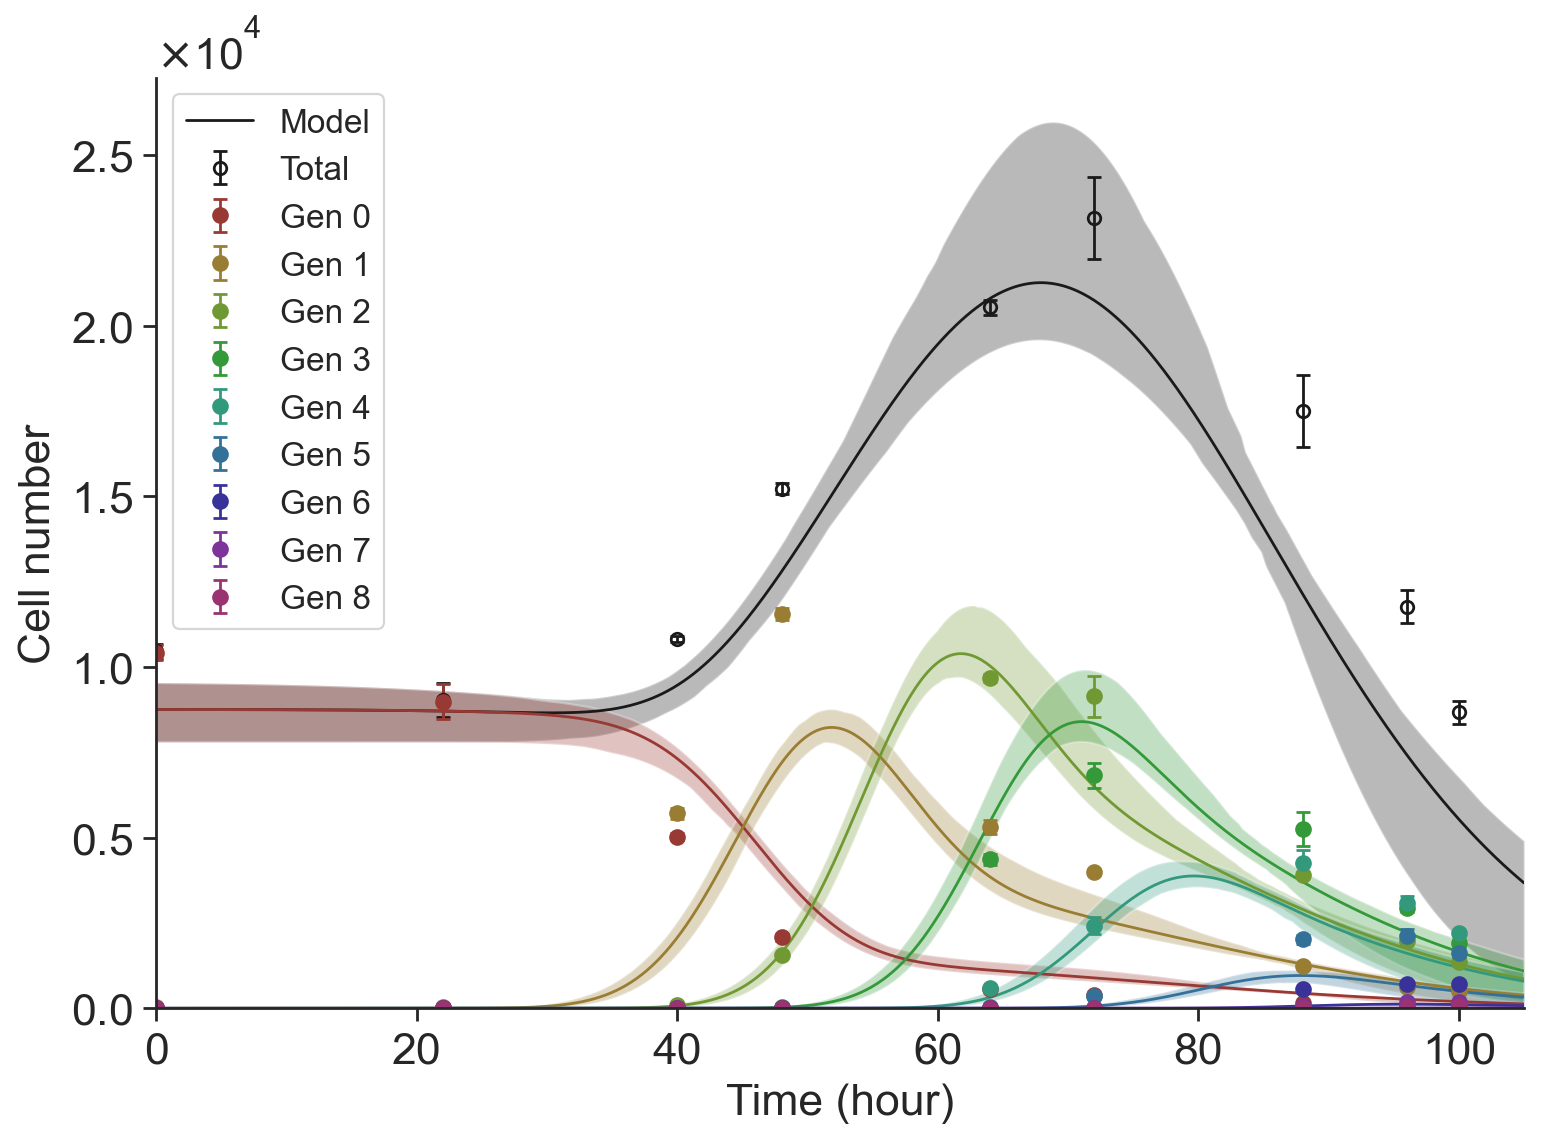

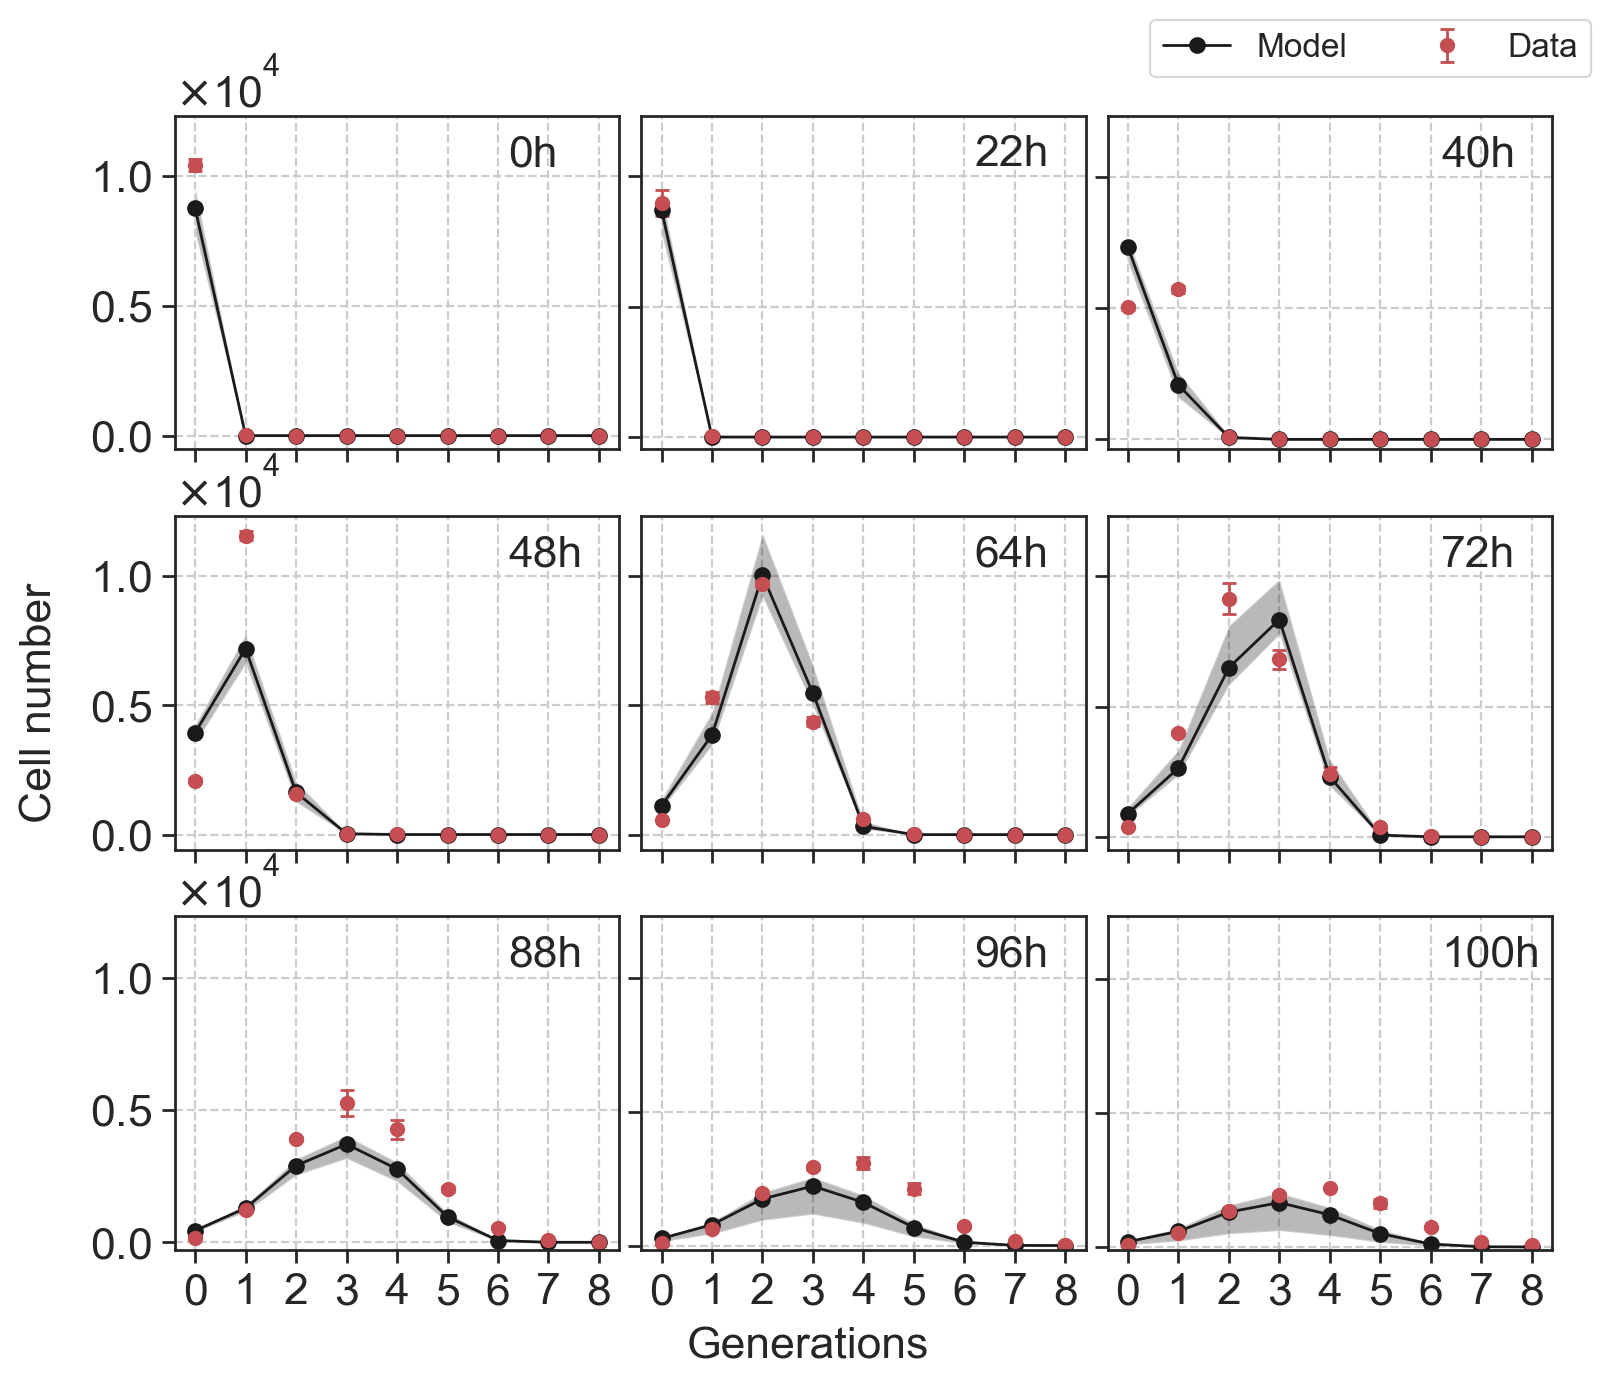

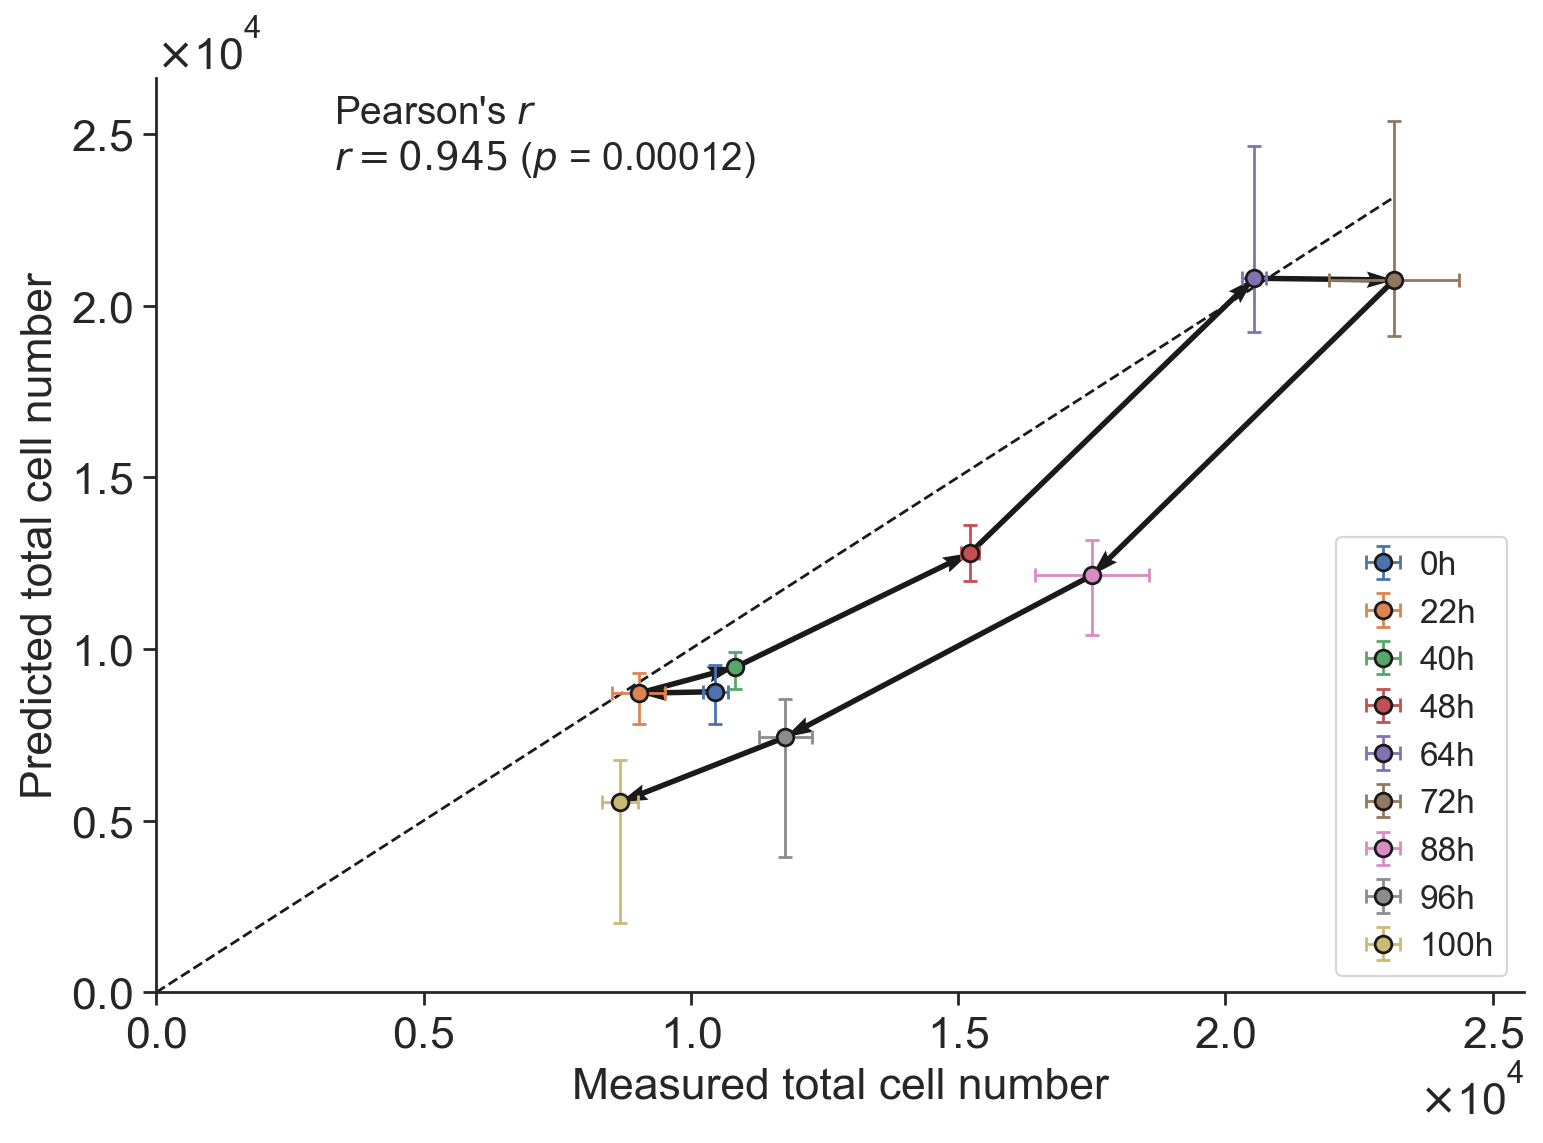

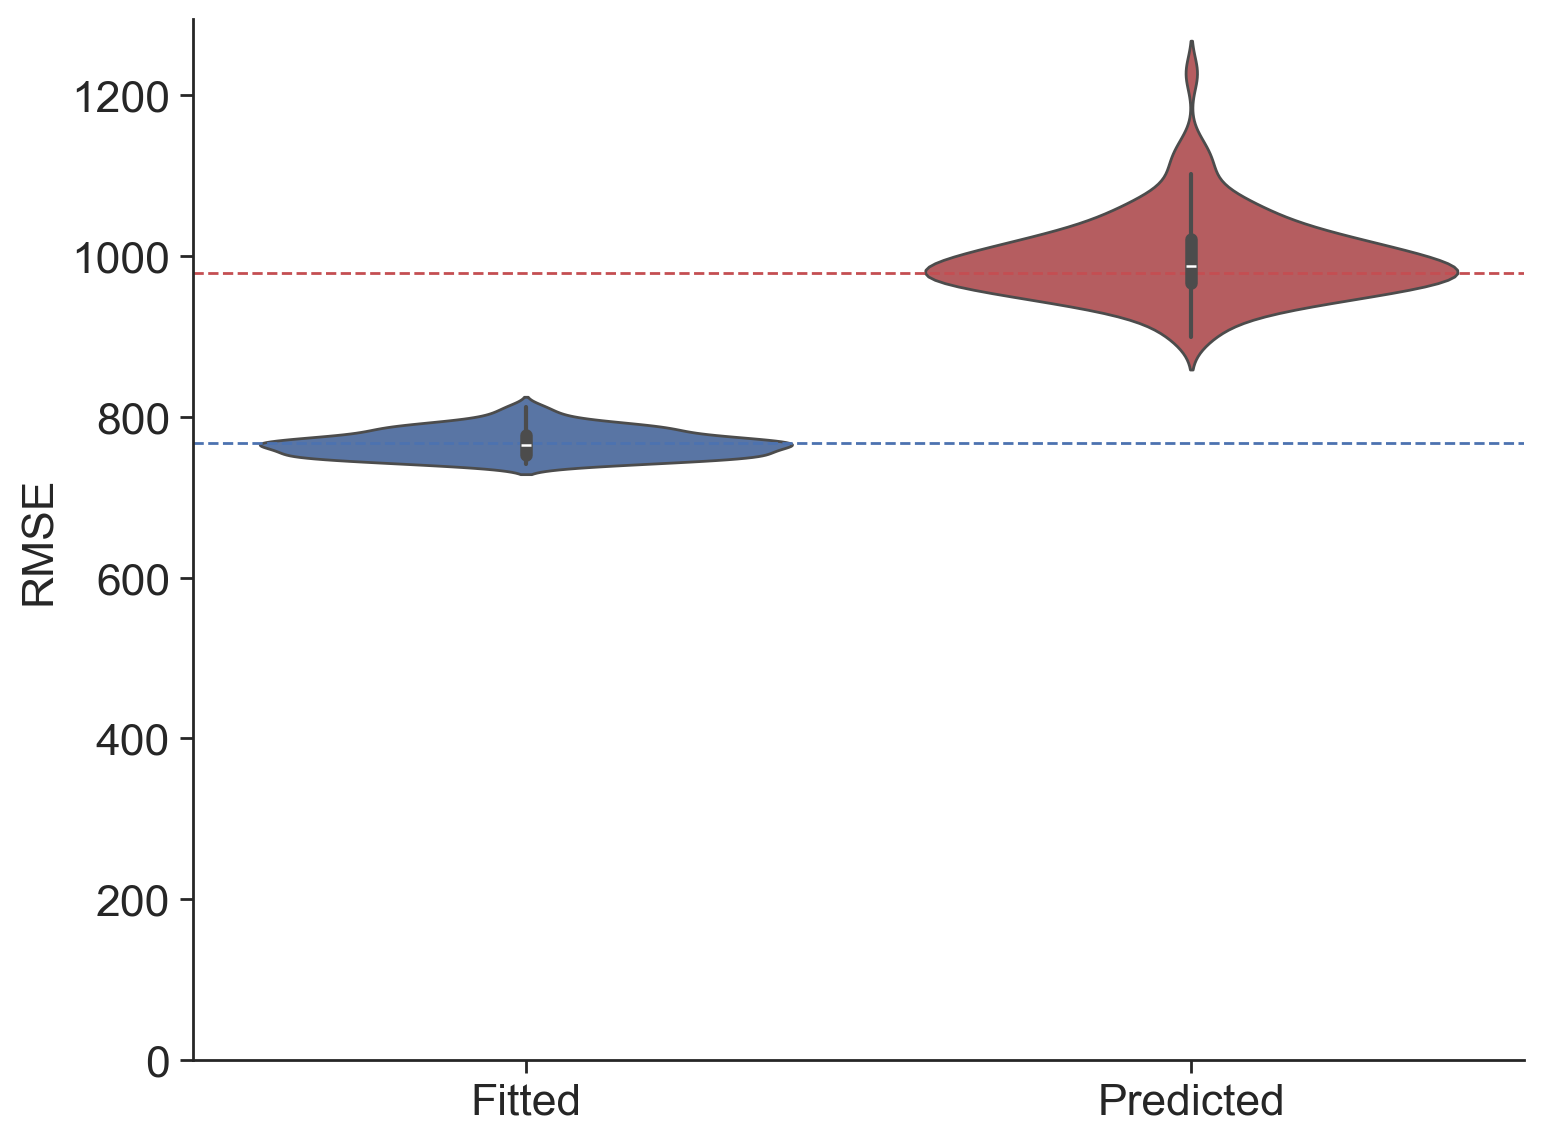

In [7]:
parsRAPA158MPA100 = pd.read_excel(f'{fitpath}/{key}_Rapa 158pgmL + MPA 100ngmL_result.xlsx', sheet_name=f'pars_Rapa158pgmL+MPA100ngmL', index_col=0)['best-fit'].to_dict()
fittedPars = parsRAPA158MPA100.copy() 
bootRAPA158MPA100 = pd.read_excel(f'{fitpath}/{key}_Rapa 158pgmL + MPA 100ngmL_result.xlsx', sheet_name=f'boot_Rapa158pgmL+MPA100ngmL', index_col=0)
fittedBoot = bootRAPA158MPA100.copy()

icnd = 7
contribRAPA158 = computeContribs(parsCTRL, parsRAPA158)
contribMPA100 = computeContribs(parsCTRL, parsMPA100)
predPars = pd.DataFrame([signalAdd(parsCTRL, contribRAPA158, contribMPA100)])
predBoot = pd.DataFrame(signalAddError(bootCTRL, bootRAPA158, bootMPA100))
# nan_cols = predBoot.columns[predBoot.isna().any()].tolist()
nan_idx = predBoot[predBoot.isnull().any(axis=1)].index
predBoot = predBoot.drop(nan_idx)
fittedBoot = fittedBoot.drop(nan_idx)
times, ext, curvesCI = predict(dfRAPA_MPA, icnd, predPars, predBoot, bootRAPA158MPA100)

path = "./out/Predictions/2. Same Timer/RAPA + MPA/DV24_003/RAPA 158 + MPA 100"
fig1, fig2, fig3, fig4, fig5 = check_prediction(dfRAPA_MPA, icnd, times, fittedPars, fittedBoot, predPars, predBoot, curvesCI, ext, path)
fig1.savefig(f"{path}/f1_predicted_PDFs.pdf", dpi=300)
fig2.savefig(f"{path}/f2_predicted_Cells.pdf", dpi=300)
fig3.savefig(f"{path}/f3_predicted_CellsGens.pdf", dpi=300)
fig4.savefig(f"{path}/f4_ModelvsData.pdf", dpi=300)
fig5.savefig(f"{path}/f5_RMSE.pdf", dpi=300)
plt.show()

## Rapa 500 + MPA 50

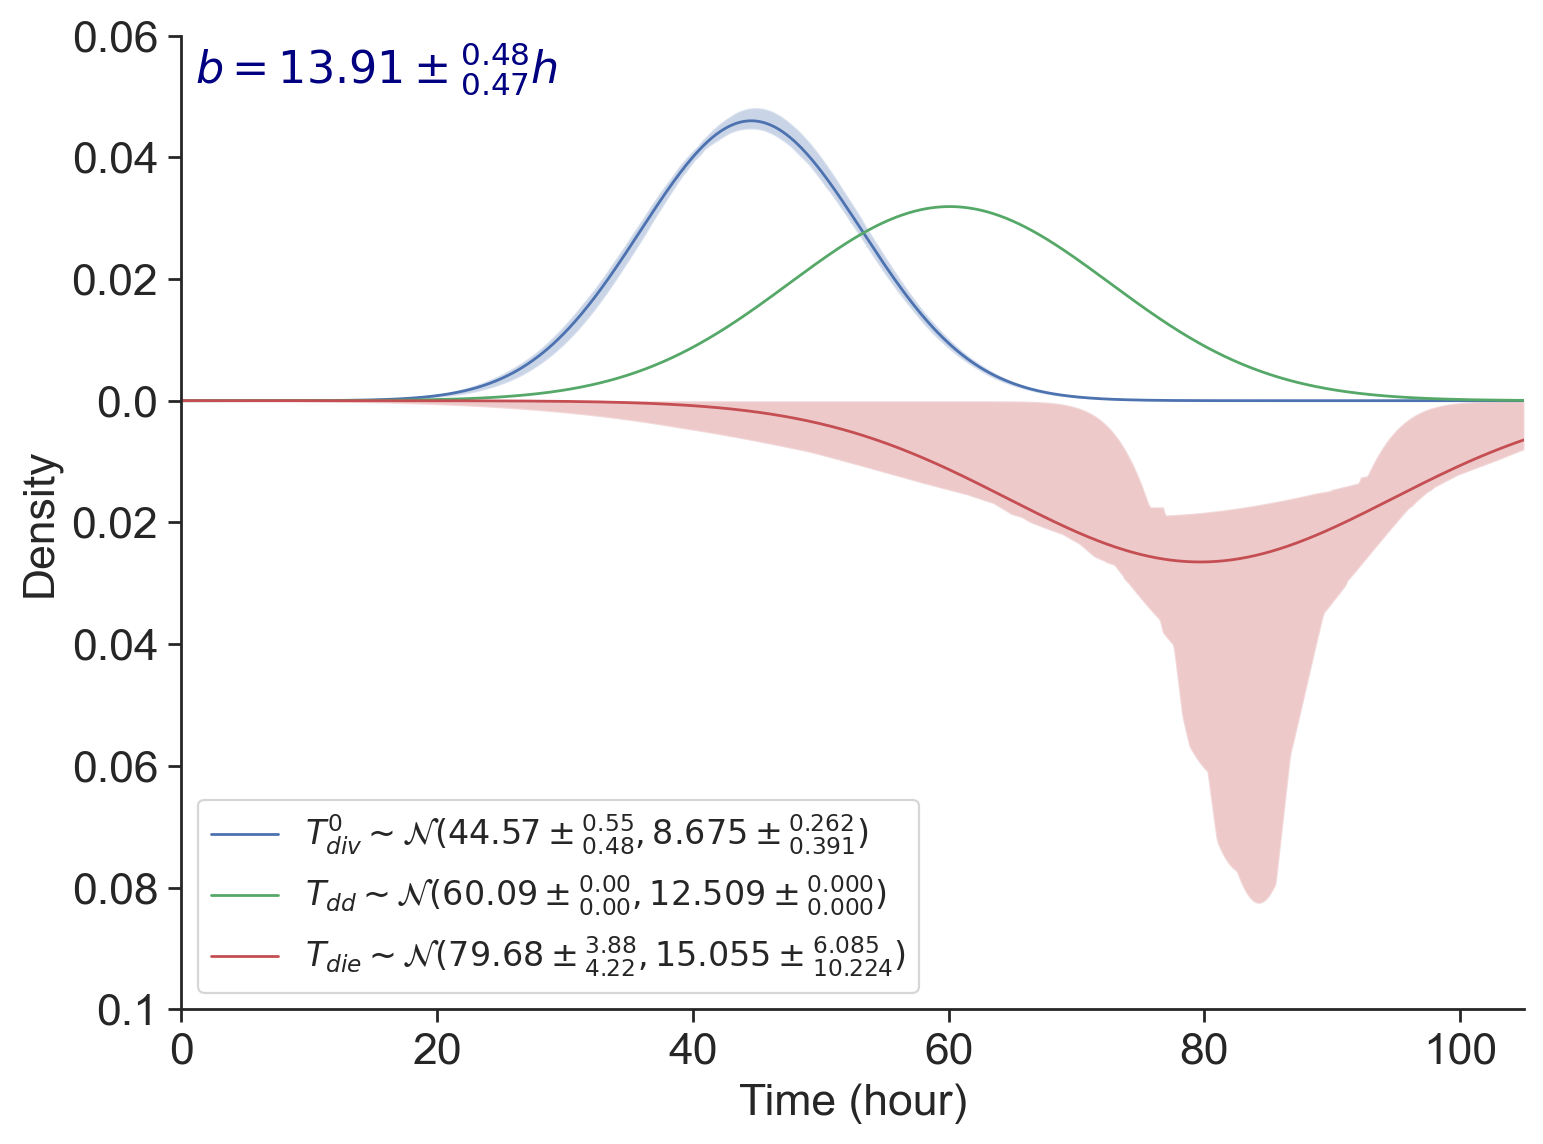

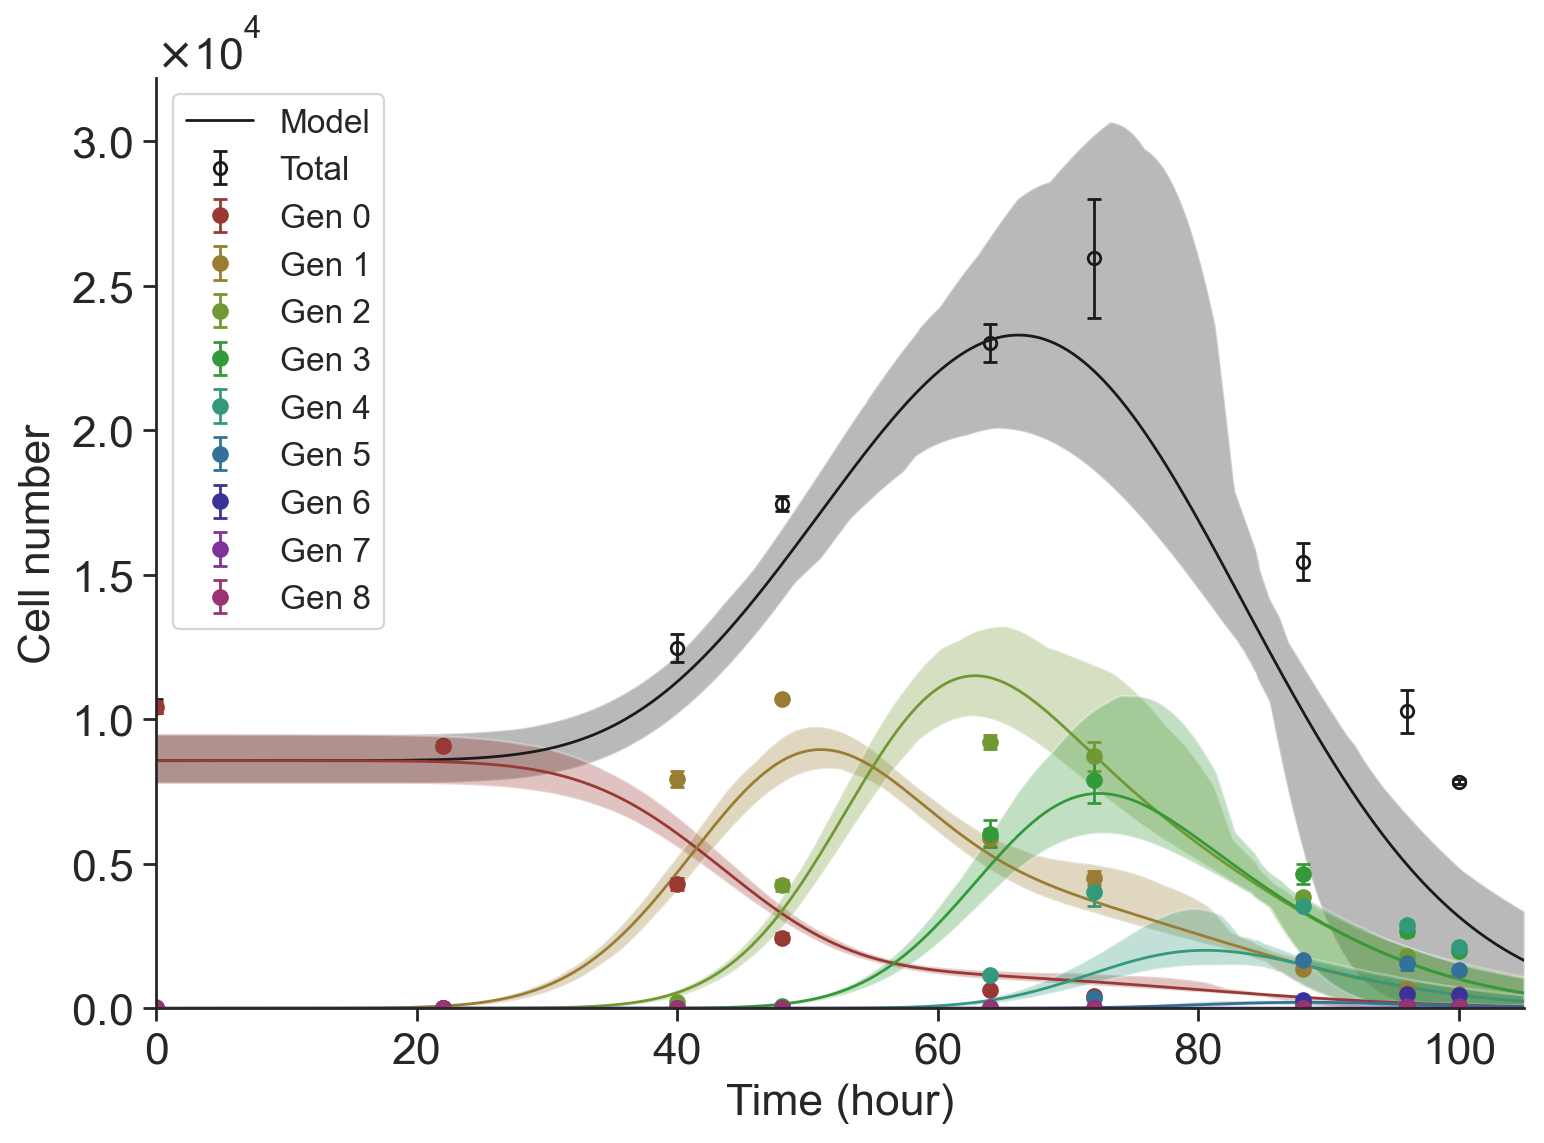

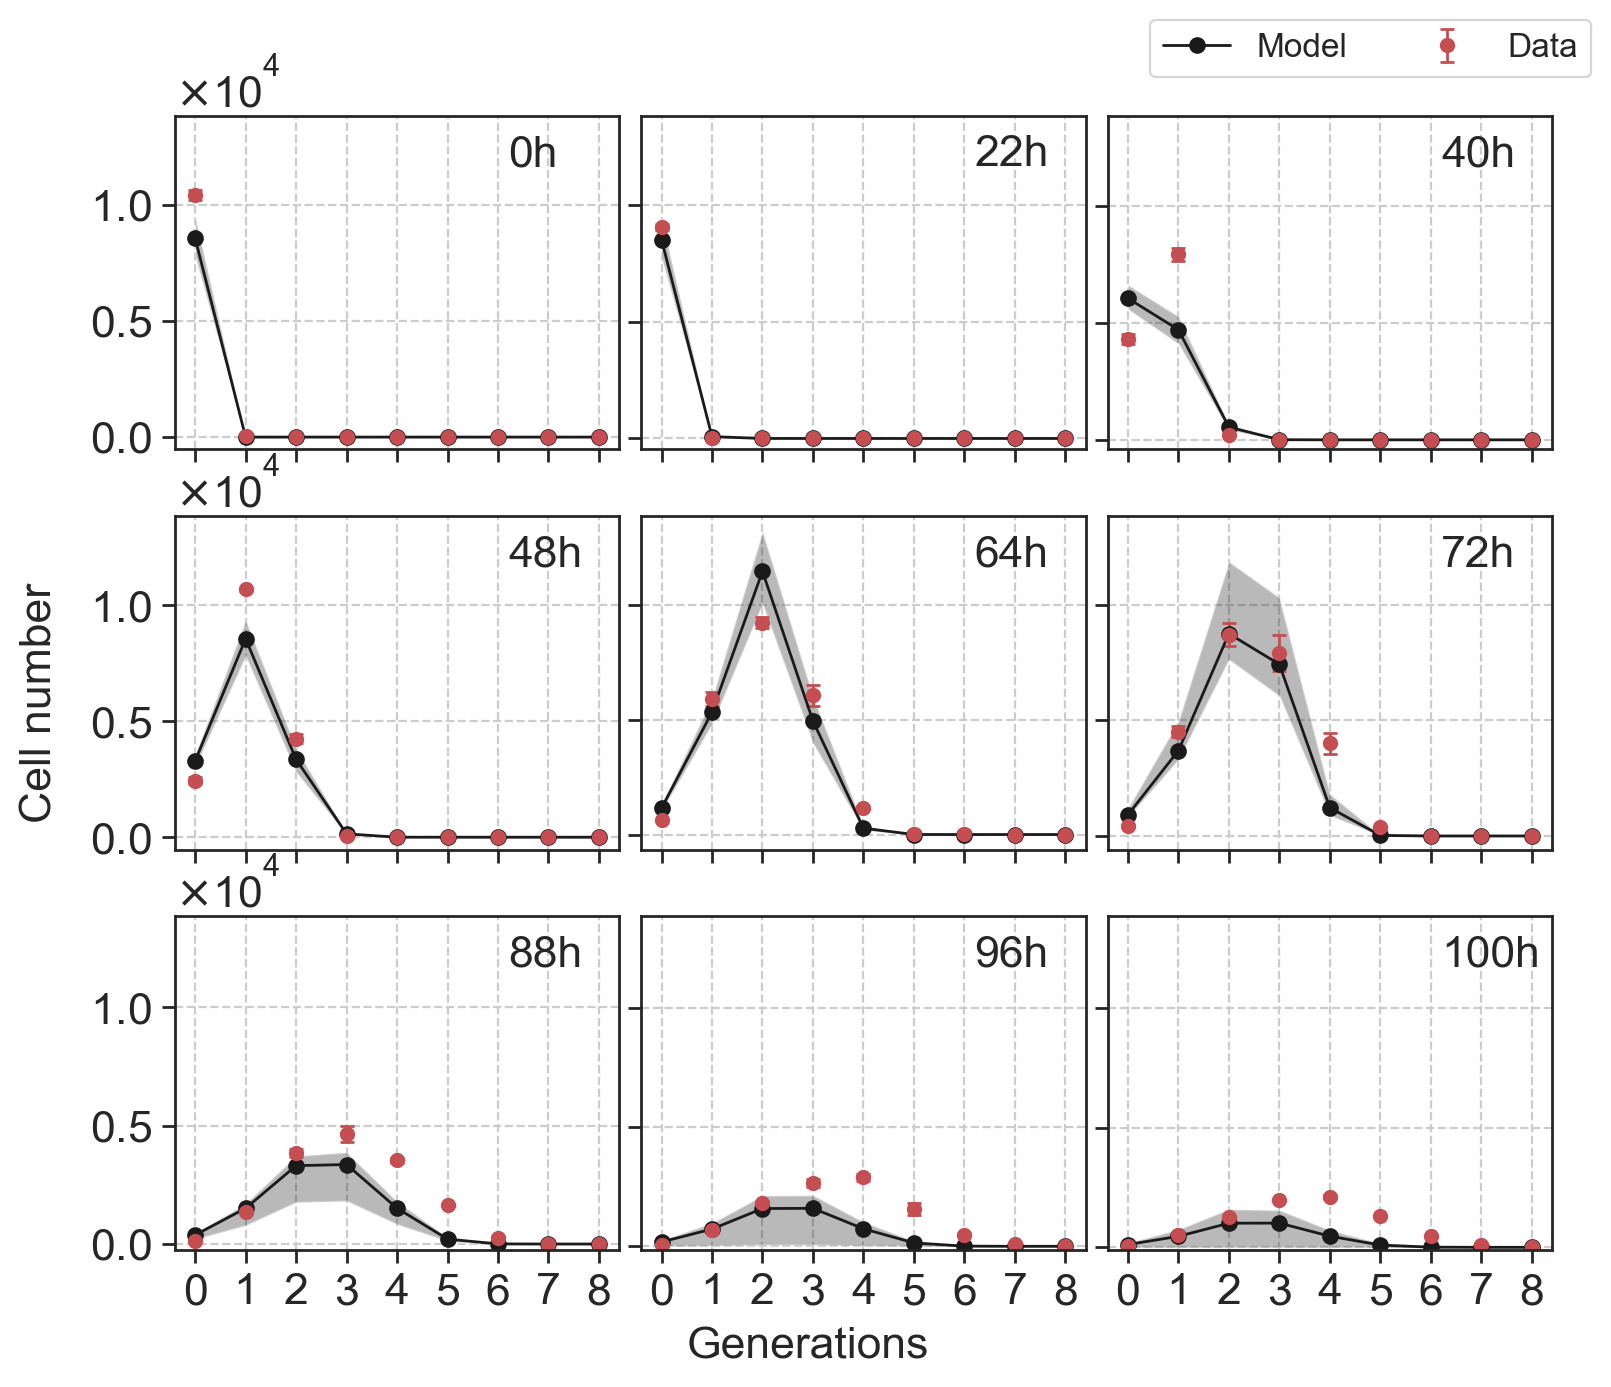

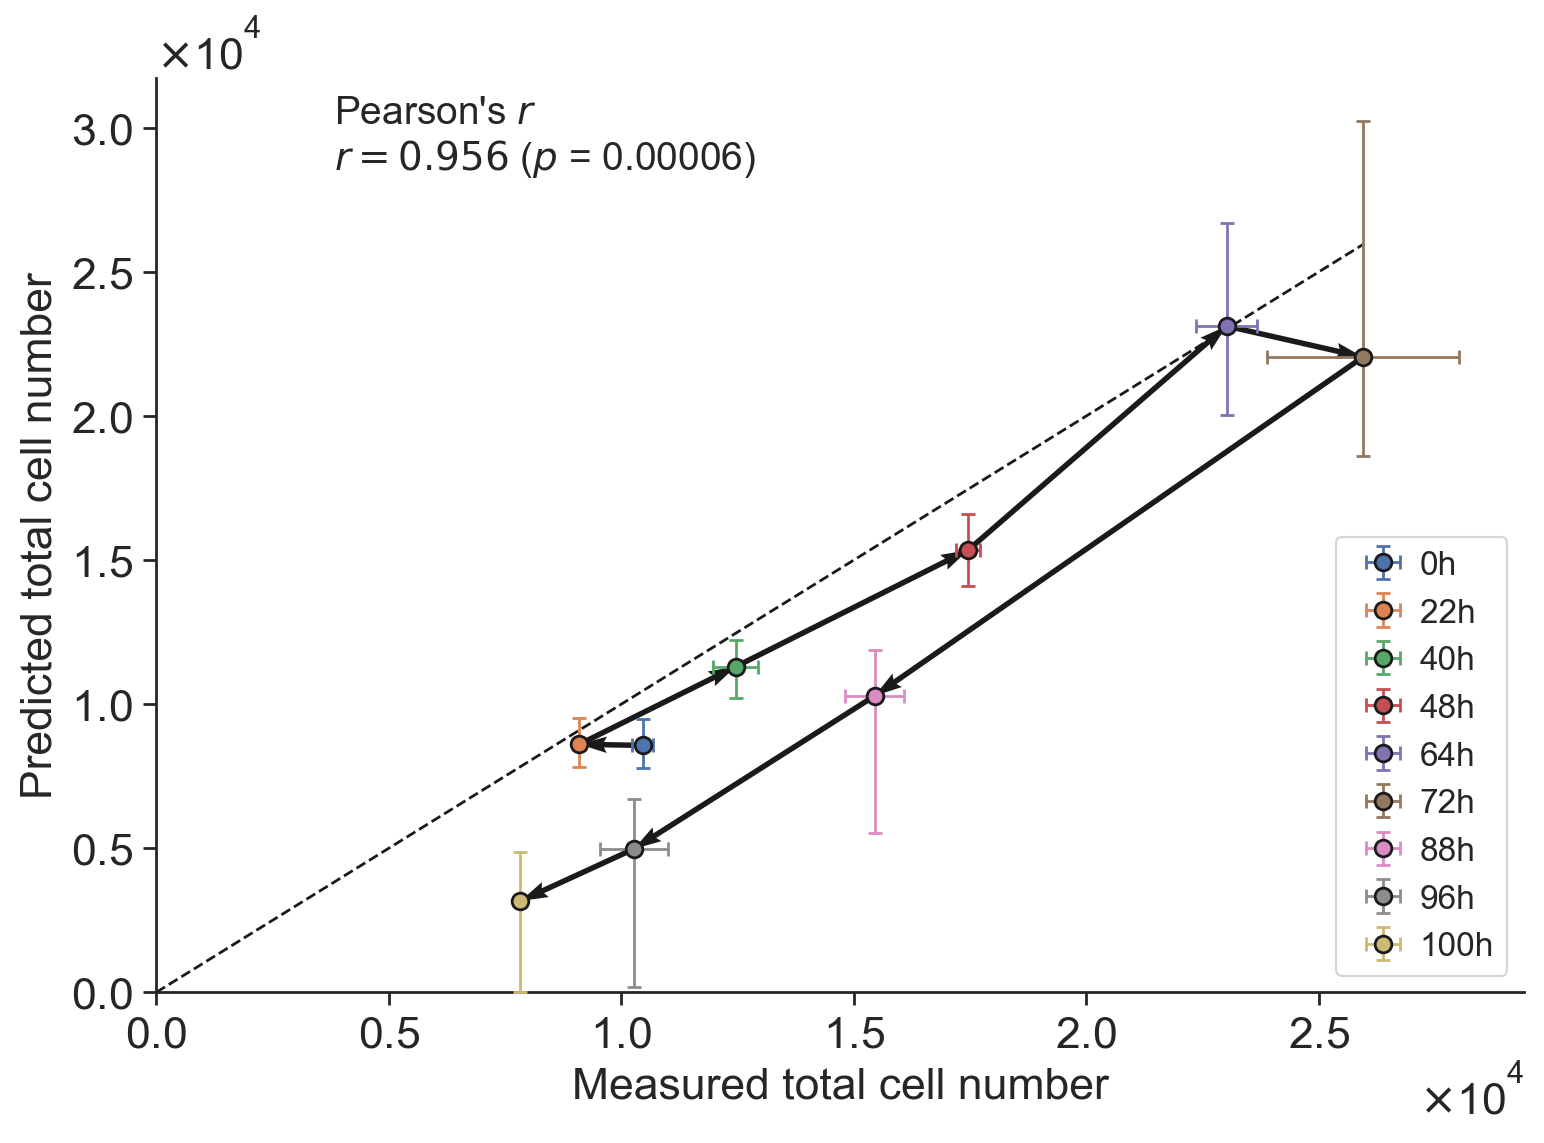

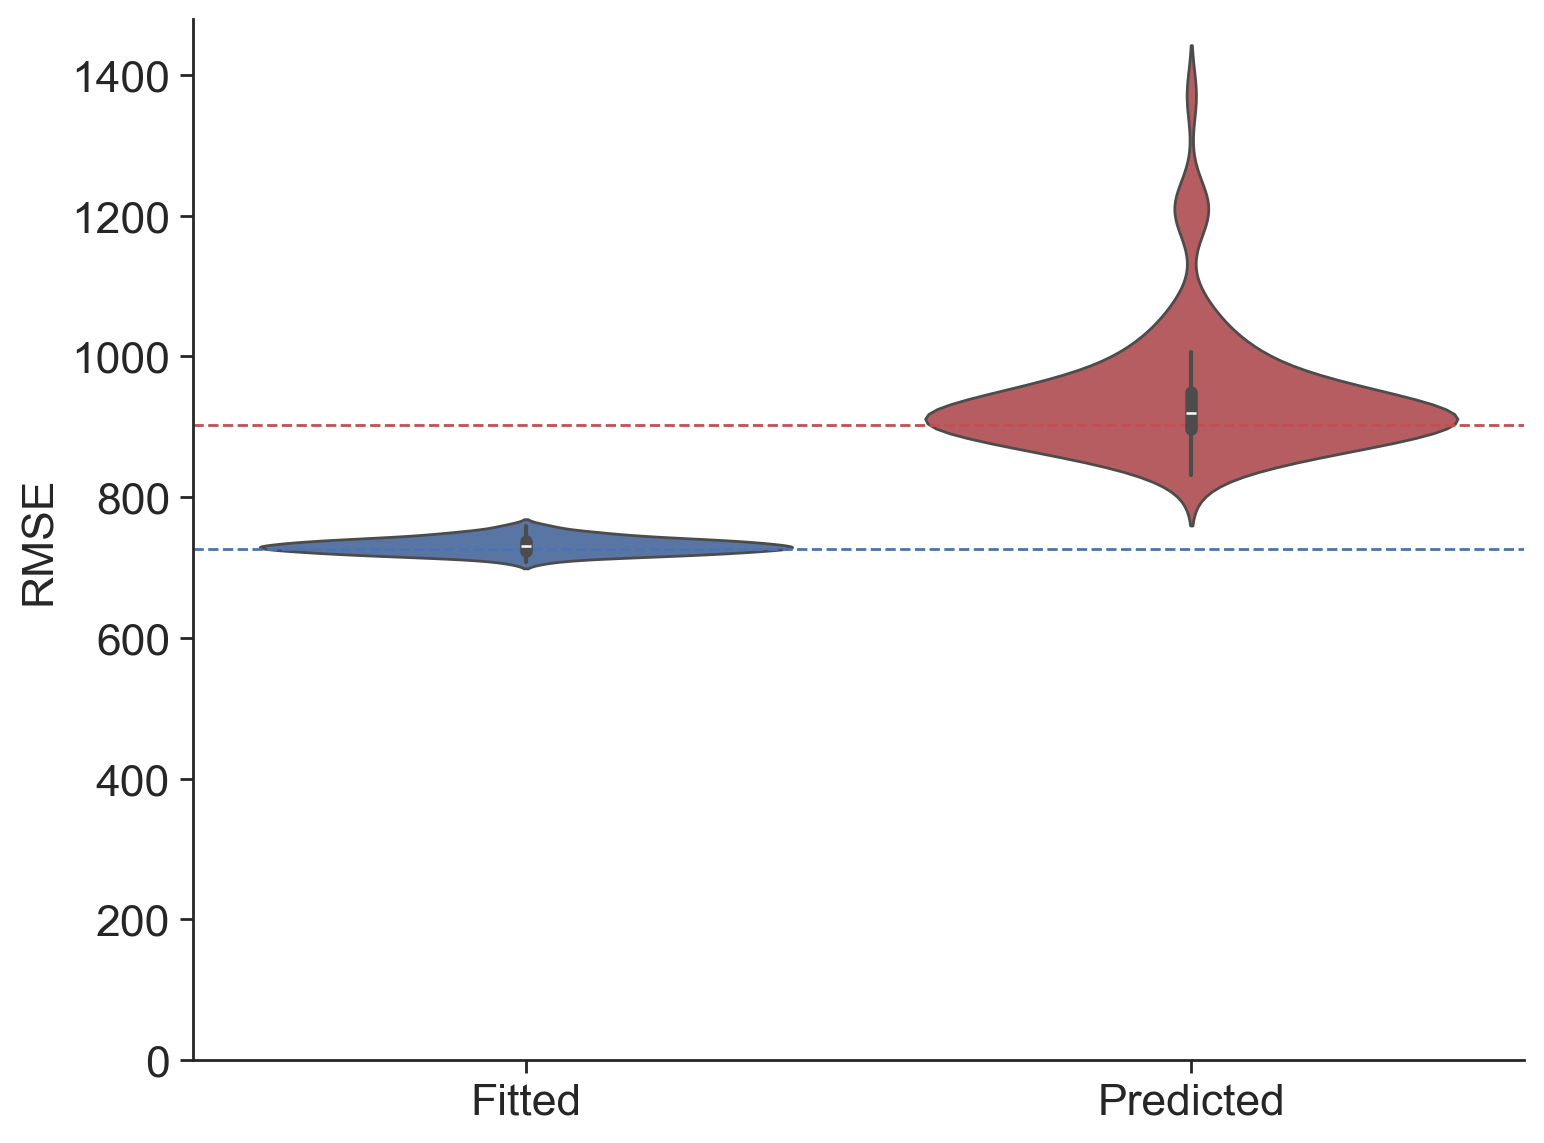

In [8]:
parsRAPA500MPA50 = pd.read_excel(f'{fitpath}/{key}_Rapa 500pgmL + MPA 50ngmL_result.xlsx', sheet_name=f'pars_Rapa500pgmL+MPA50ngmL', index_col=0)['best-fit'].to_dict()
fittedPars = parsRAPA500MPA50.copy() 
bootRAPA500MPA50 = pd.read_excel(f'{fitpath}/{key}_Rapa 500pgmL + MPA 50ngmL_result.xlsx', sheet_name=f'boot_Rapa500pgmL+MPA50ngmL', index_col=0)
fittedBoot = bootRAPA500MPA50.copy()

icnd = 5
contribRAPA500 = computeContribs(parsCTRL, parsRAPA500)
contribMPA50 = computeContribs(parsCTRL, parsMPA50)
predPars = pd.DataFrame([signalAdd(parsCTRL, contribRAPA500, contribMPA50)])
predBoot = pd.DataFrame(signalAddError(bootCTRL, bootRAPA500, bootMPA50))
# nan_cols = predBoot.columns[predBoot.isna().any()].tolist()
nan_idx = predBoot[predBoot.isnull().any(axis=1)].index
predBoot = predBoot.drop(nan_idx)
fittedBoot = fittedBoot.drop(nan_idx)
times, ext, curvesCI = predict(dfRAPA_MPA, icnd, predPars, predBoot, bootRAPA500MPA50)

path = "./out/Predictions/2. Same Timer/RAPA + MPA/DV24_003/RAPA 500 + MPA 50"
fig1, fig2, fig3, fig4, fig5 = check_prediction(dfRAPA_MPA, icnd, times, fittedPars, fittedBoot, predPars, predBoot, curvesCI, ext, path)
fig1.savefig(f"{path}/f1_predicted_PDFs.pdf", dpi=300)
fig2.savefig(f"{path}/f2_predicted_Cells.pdf", dpi=300)
fig3.savefig(f"{path}/f3_predicted_CellsGens.pdf", dpi=300)
fig4.savefig(f"{path}/f4_ModelvsData.pdf", dpi=300)
fig5.savefig(f"{path}/f5_RMSE.pdf", dpi=300)
plt.show()

## Rapa 500 + MPA 100

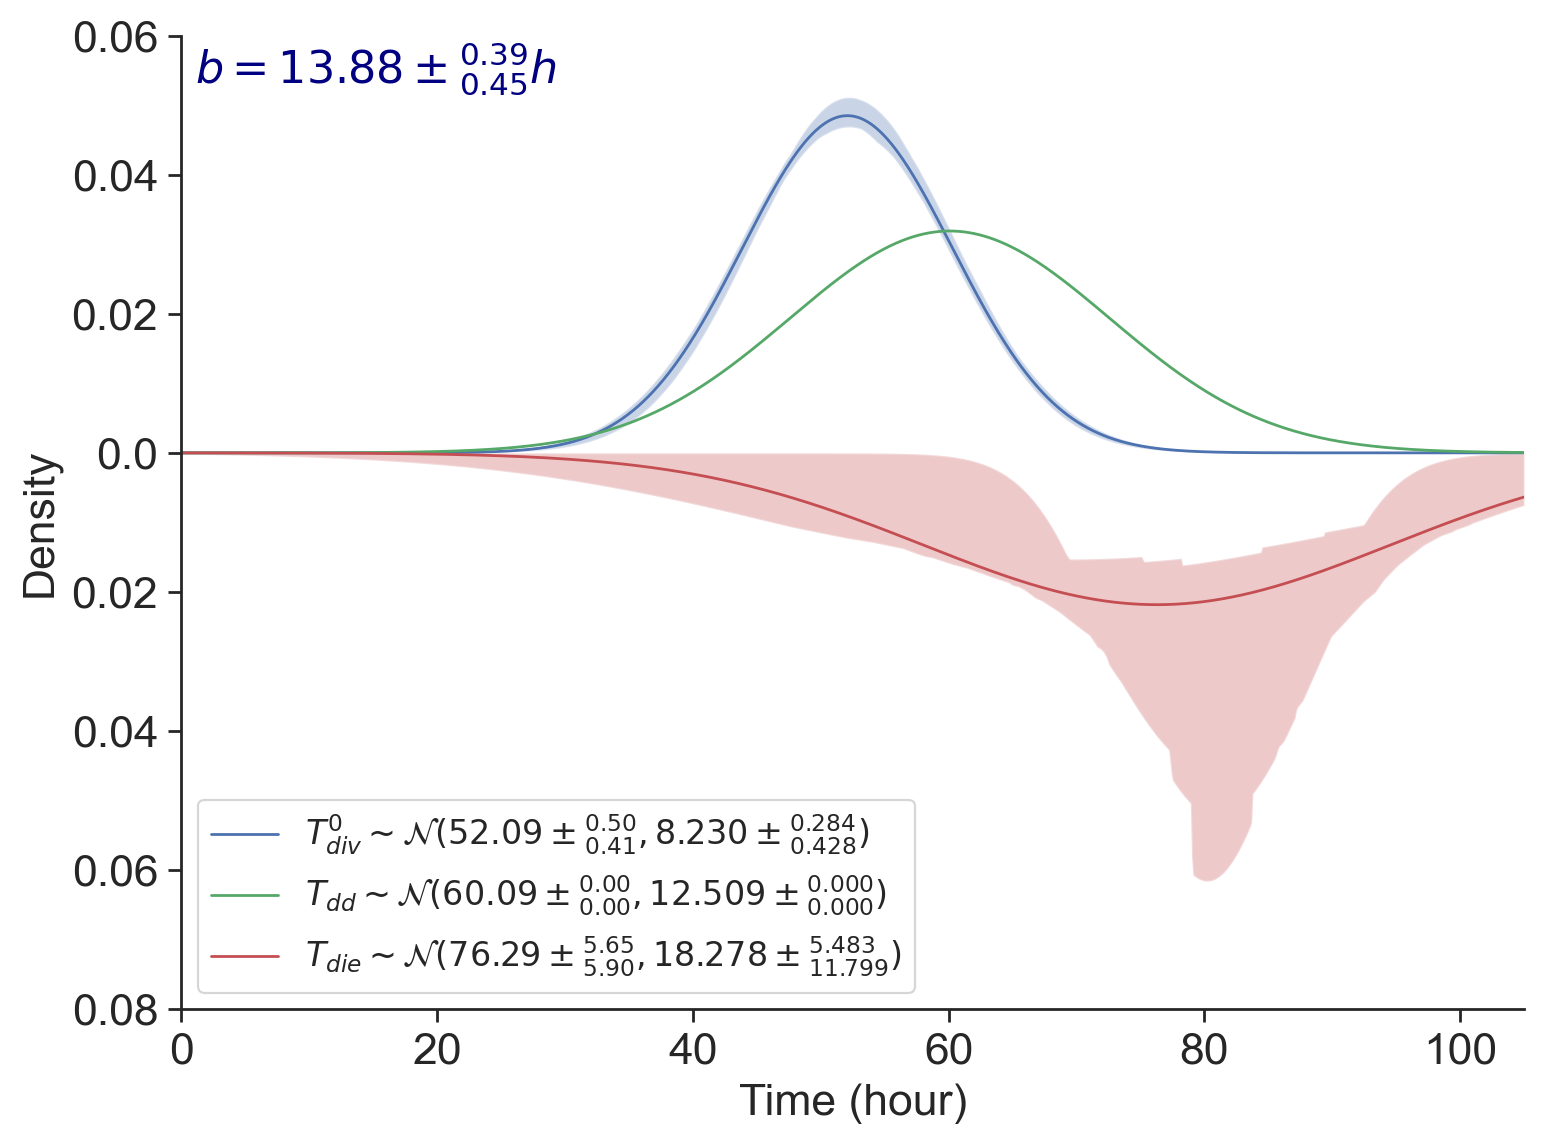

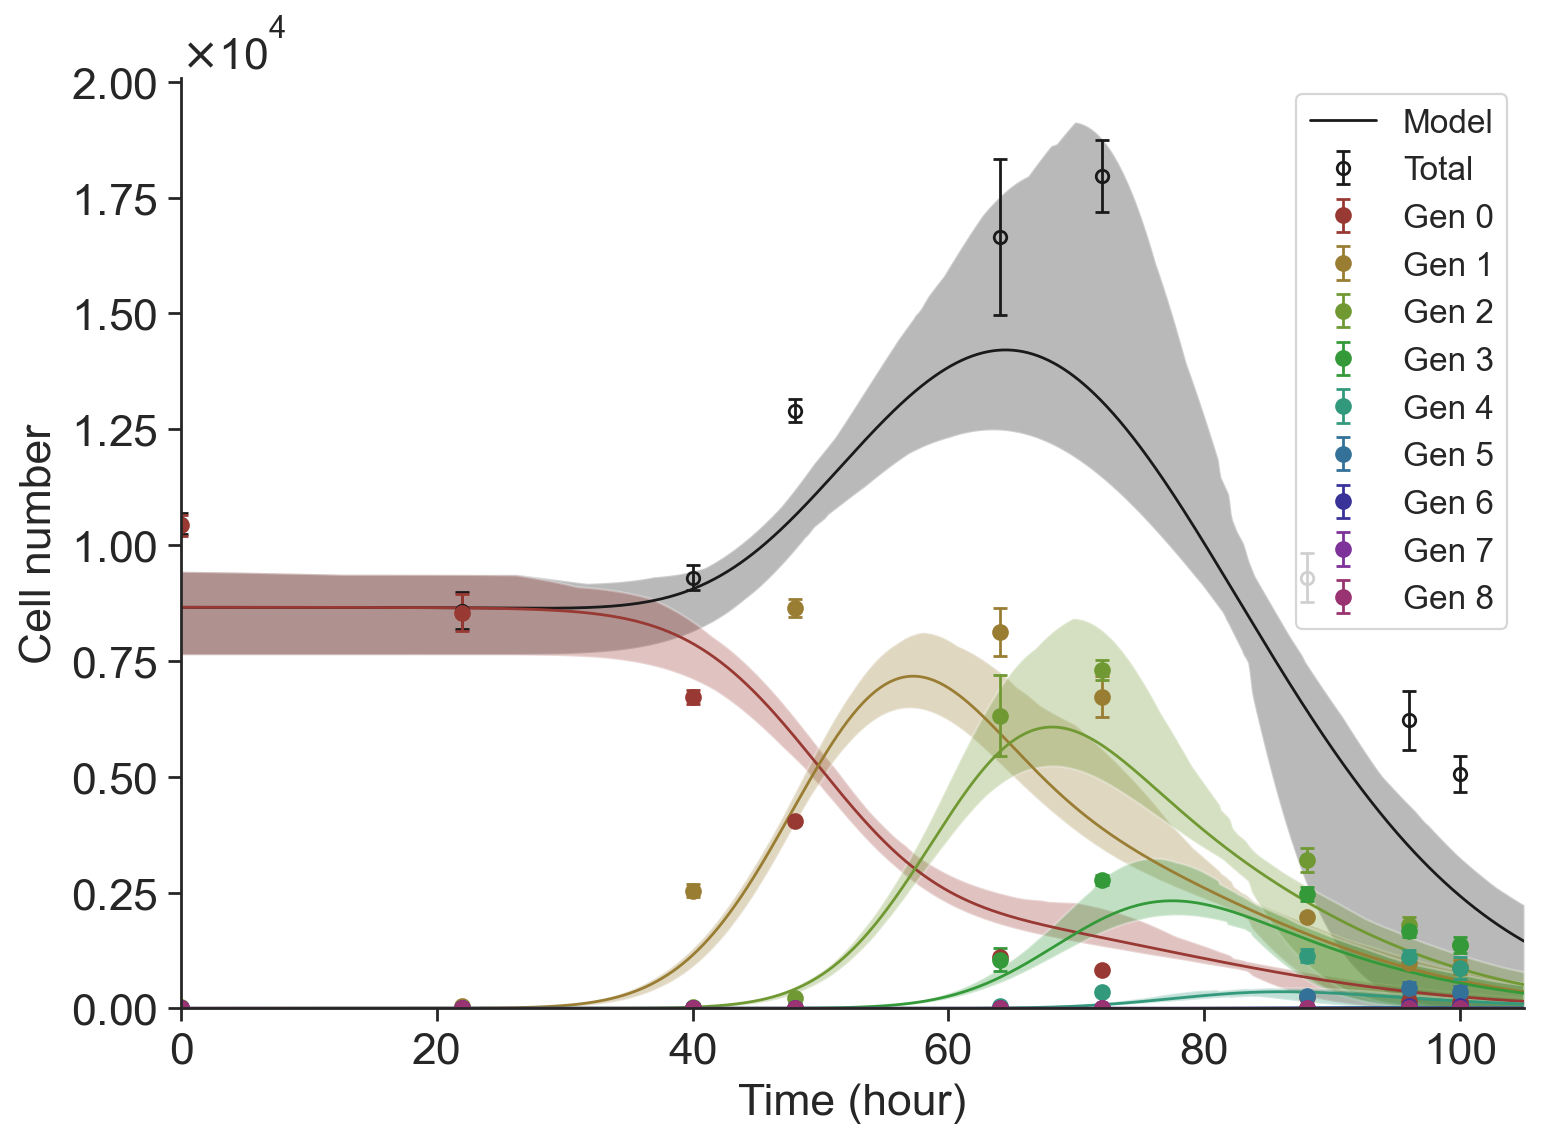

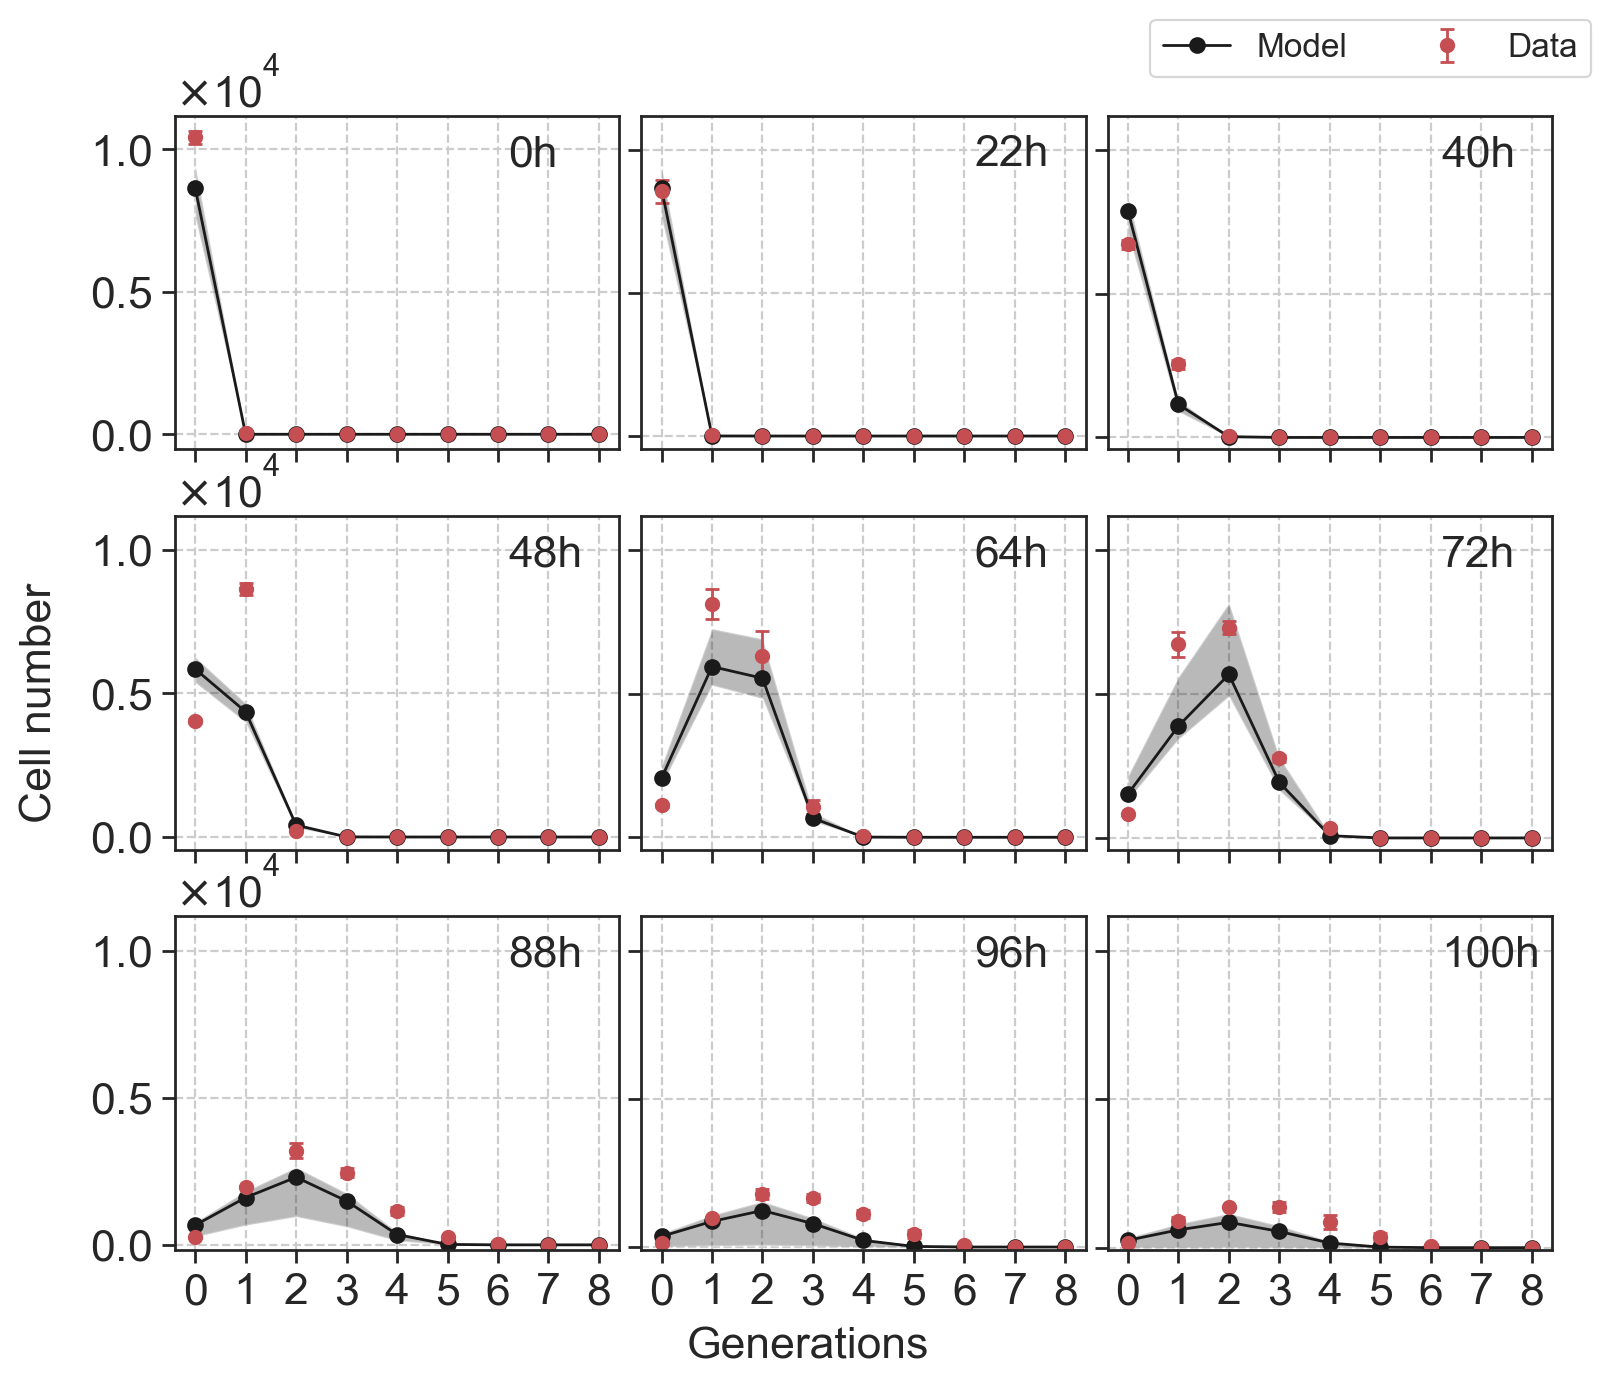

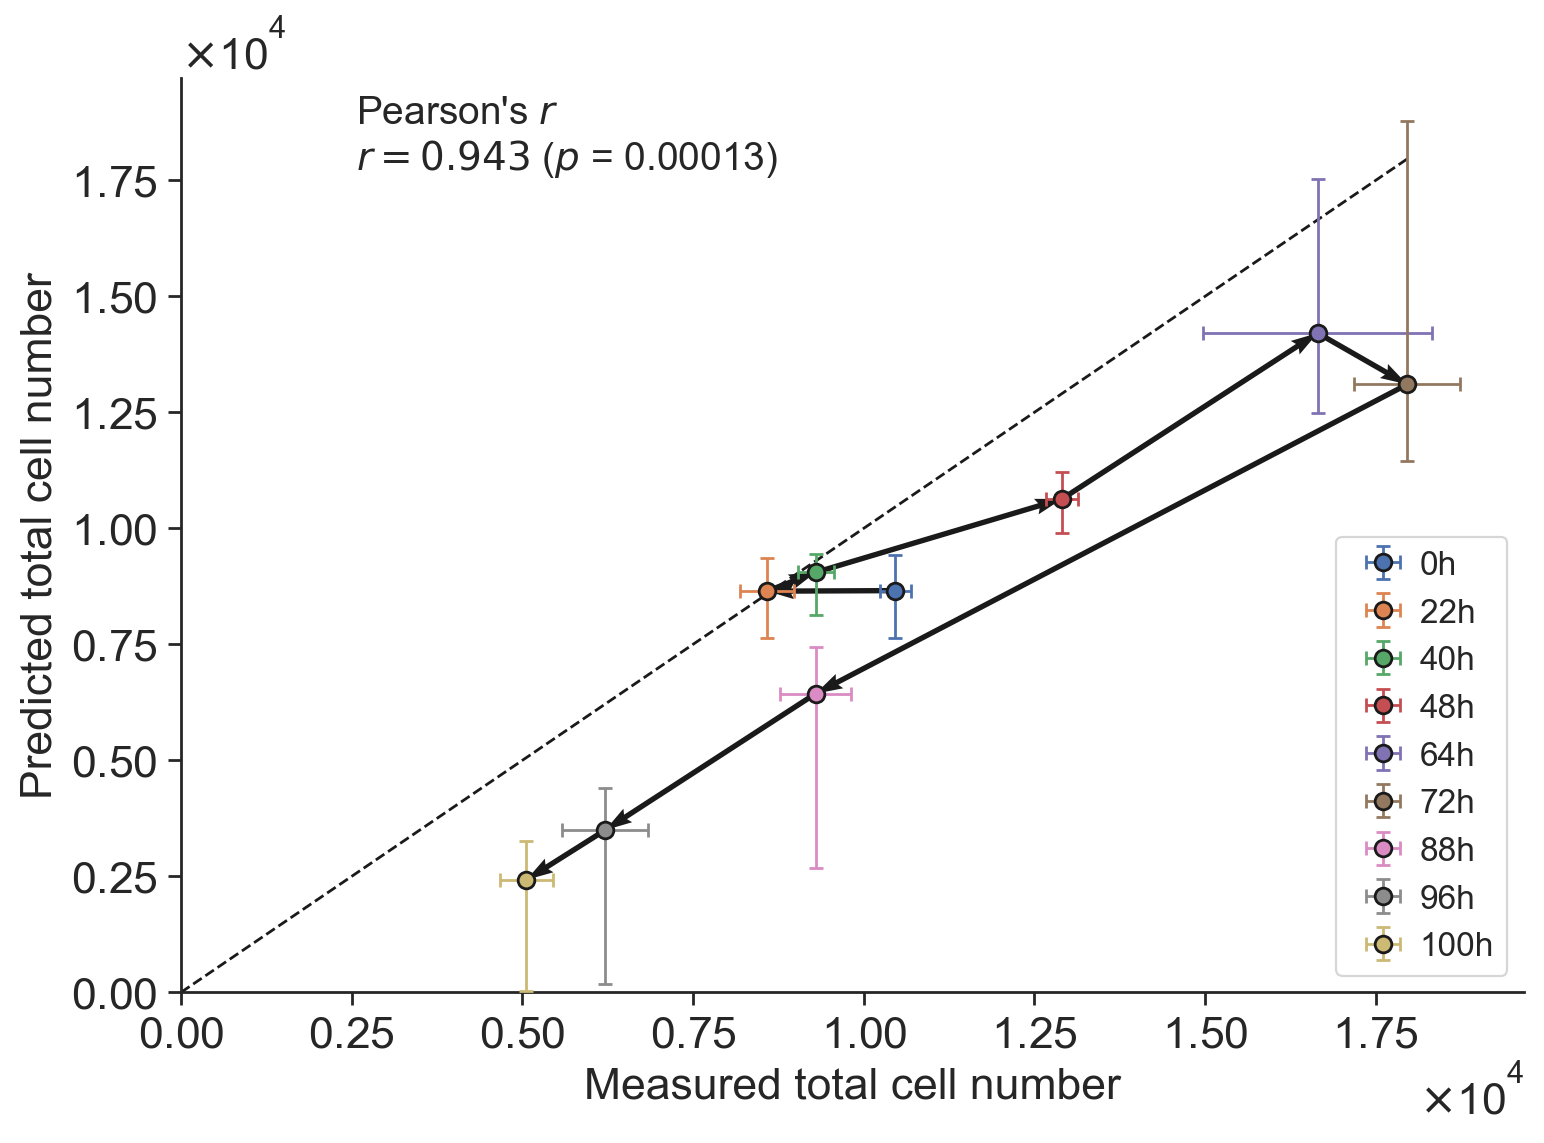

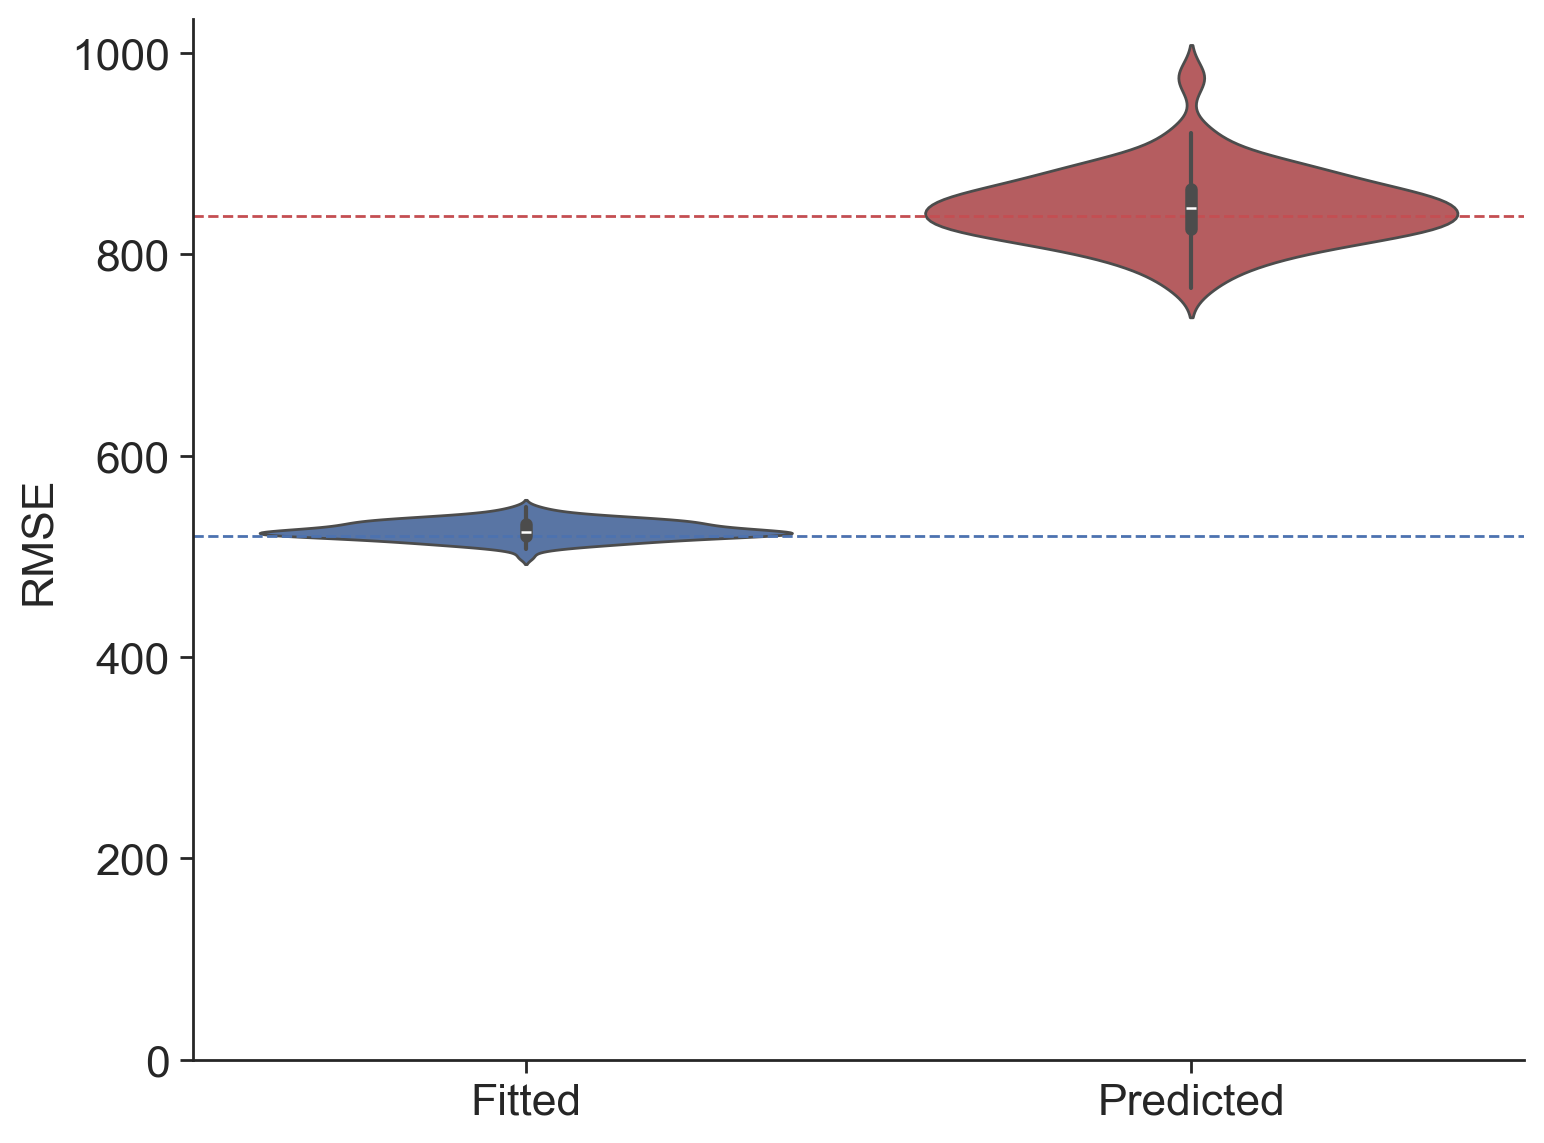

In [9]:
parsRAPA500MPA100 = pd.read_excel(f'{fitpath}/{key}_Rapa 500pgmL + MPA 100ngmL_result.xlsx', sheet_name=f'pars_Rapa500pgmL+MPA100ngmL', index_col=0)['best-fit'].to_dict()
fittedPars = parsRAPA500MPA100.copy() 
bootRAPA500MPA100 = pd.read_excel(f'{fitpath}/{key}_Rapa 500pgmL + MPA 100ngmL_result.xlsx', sheet_name=f'boot_Rapa500pgmL+MPA100ngmL', index_col=0)
fittedBoot = bootRAPA500MPA100.copy()

icnd = 8
contribRAPA500 = computeContribs(parsCTRL, parsRAPA500)
contribMPA100 = computeContribs(parsCTRL, parsMPA100)
predPars = pd.DataFrame([signalAdd(parsCTRL, contribRAPA500, contribMPA100)])
predBoot = pd.DataFrame(signalAddError(bootCTRL, bootRAPA500, bootMPA100))
# nan_cols = predBoot.columns[predBoot.isna().any()].tolist()
nan_idx = predBoot[predBoot.isnull().any(axis=1)].index
predBoot = predBoot.drop(nan_idx)
fittedBoot = fittedBoot.drop(nan_idx)
times, ext, curvesCI = predict(dfRAPA_MPA, icnd, predPars, predBoot, bootRAPA500MPA100)

path = "./out/Predictions/2. Same Timer/RAPA + MPA/DV24_003/RAPA 500 + MPA 100"
fig1, fig2, fig3, fig4, fig5 = check_prediction(dfRAPA_MPA, icnd, times, fittedPars, fittedBoot, predPars, predBoot, curvesCI, ext, path)
fig1.savefig(f"{path}/f1_predicted_PDFs.pdf", dpi=300)
fig2.savefig(f"{path}/f2_predicted_Cells.pdf", dpi=300)
fig3.savefig(f"{path}/f3_predicted_CellsGens.pdf", dpi=300)
fig4.savefig(f"{path}/f4_ModelvsData.pdf", dpi=300)
fig5.savefig(f"{path}/f5_RMSE.pdf", dpi=300)
plt.show()

## Summary layout

In [10]:
rc = {
	# 'axes.grid': True, 'axes.grid.axis': 'x', 'axes.grid.axis': 'y',
	'axes.axisbelow': True, 'axes.titlepad': 0,
	'axes.spines.top': True, 'axes.spines.right': True,
	'axes.spines.left': True, 'axes.spines.bottom': True,
	'ytick.left': True, 'xtick.bottom': True,
	'lines.markersize': 5, 'lines.linewidth': 1,
	'errorbar.capsize': 2.5
}
sns.set(context='paper', style='white', rc=rc)

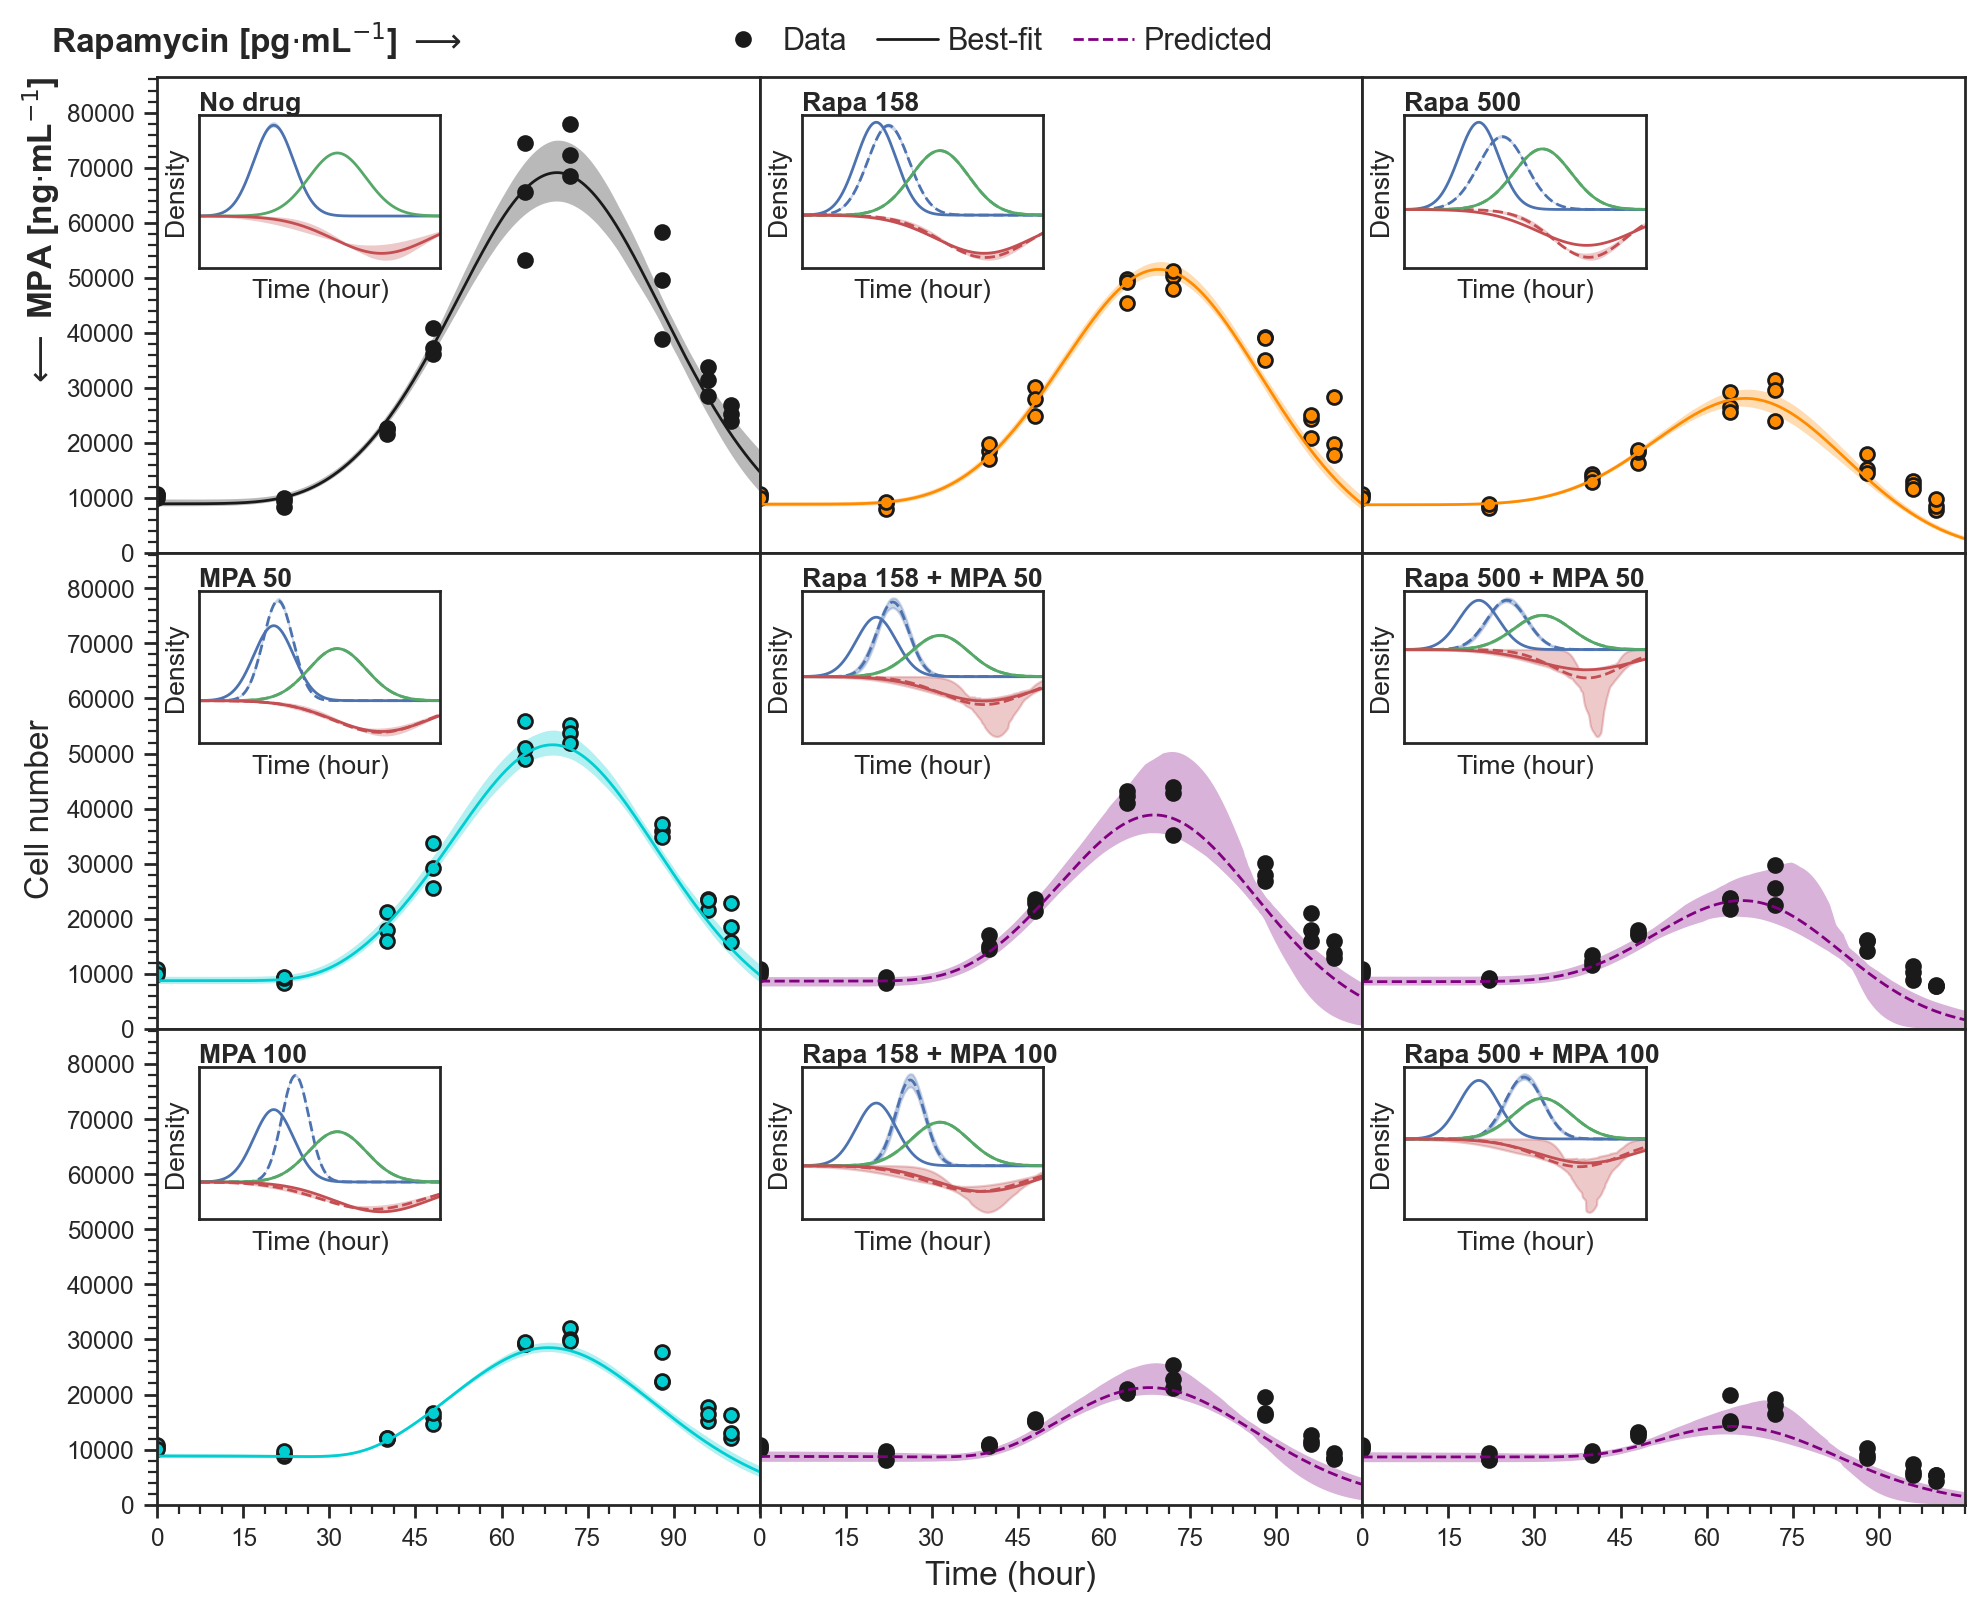

In [11]:
key = 'DV24_003 Rapa+MPA'

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,8))
ax = ax.flat
fig.tight_layout(rect=(0.03, 0.02, 1, 0.98))
fig.subplots_adjust(hspace=0, wspace=0)

fig.text(0.02, 0.98, "Rapamycin [pg$\cdot$mL$^{-1}$] $\longrightarrow$", ha='left', va='center', fontweight='bold', fontsize=12)
fig.text(0.015, 0.86, "$\longleftarrow$ MPA [ng$\cdot$mL$^{-1}$]", ha='center', va='center', rotation=90, fontweight='bold', fontsize=12)
fig.text(0.015, 0.5, "Cell number", ha='center', va='center', rotation=90, fontweight='normal', fontsize=12)
fig.text(0.5, 0.02, "Time (hour)", ha='center', va='center', fontweight='normal', fontsize=12)

labels = ['No drug', 'Rapa 158', 'Rapa 500', 
		  			 'MPA 50', 'Rapa 158 + MPA 50', 'Rapa 500 + MPA 50',
					 'MPA 100', 'Rapa 158 + MPA 100', 'Rapa 500 + MPA 100']
c_no_drug = c_predict = 'k'
c_rapa = 'darkorange'
c_mpa = 'darkturquoise'


basePars = pars = pd.read_excel(f'{fitpath}/{key}_No drug_result.xlsx', sheet_name=f'pars_Nodrug', index_col=0)['best-fit']

conds = dfRAPA_MPA['reader'].condition_names[:-1]
max_ylim = 0
for icnd, c in enumerate(conds):
	crep = c.replace("Rapamycin", "Rapa").replace(" ", "")
	ax[icnd].annotate(labels[icnd], xy=(0.07, 0.93), xycoords='axes fraction', fontweight='bold', ha='left')
	pars = pd.read_excel(f'{fitpath}/{key}_{c}_result.xlsx', sheet_name=f'pars_{crep}', index_col=0)['best-fit']
	boots = pd.read_excel(f'{fitpath}/{key}_{c}_result.xlsx', sheet_name=f'boot_{crep}', index_col=0)

	mgen = dfRAPA_MPA['reader'].generation_per_condition[icnd]

	hts_reps = dfRAPA_MPA['reader'].harvested_times_reps[icnd]
	data_total_cells = np.ravel(dfRAPA_MPA['cells']['rep'][icnd])
	if icnd == 0:
		ax[icnd].plot(hts_reps, data_total_cells, 'o', c=c_no_drug, label="Data")
	elif icnd in [1, 2]:
		ax[icnd].plot(hts_reps, data_total_cells, 'o', c=c_rapa, mec='k', label="Data")
	elif icnd in [3, 6]:
		ax[icnd].plot(hts_reps, data_total_cells, 'o', c=c_mpa, mec='k', label="Data")
	else:
		ax[icnd].plot(hts_reps, data_total_cells, 'o', c=c_predict, label="Data")

	hts = dfRAPA_MPA['reader'].harvested_times[icnd]
	# data_total_cells = dfRAPA_MPA['cells']['avg'][icnd]
	# data_total_cells_sem = dfRAPA_MPA['cells']['sem'][icnd]
	# ax[icnd].errorbar(hts, data_total_cells, yerr=data_total_cells_sem, fmt='o', c='k')

	t0, tf, dt = 0, max(hts)+5, 0.1
	times = np.linspace(t0, tf, num=int(tf/dt)+1)
	if icnd in [0, 1, 2, 3, 6]:
		# Plot total cells
		model = Cyton2Model(hts, pars['N1'], mgen, dt, [], logn=False)
		ext = model.extrapolate(times, pars)
		model_total_cells = ext['ext']['total_live_cells']
		if icnd == 0:
			ax[icnd].plot(times, model_total_cells, c=c_no_drug, label="Best-fit")
		elif icnd in [1, 2]:
			ax[icnd].plot(times, model_total_cells, c=c_rapa, label="Best-fit")
		elif icnd in [3, 6]:
			ax[icnd].plot(times, model_total_cells, c=c_mpa, label="Best-fit")

		# Plot PDFs in inset
		e = ax[icnd].inset_axes([0.07, 0.6, 0.4, 0.32])
		tdiv0 = norm_pdf(times, pars['mDiv0'], pars['sDiv0'])
		tdd = norm_pdf(times, pars['mDD'], pars['sDD'])
		tdie = norm_pdf(times, pars['mDie'], pars['sDie'])
		if icnd == 0:
			e.plot(times, tdiv0, 'b-')
			e.plot(times, tdd, 'g-')
			e.plot(times, -tdie, 'r-')
		else:
			e.plot(times, tdiv0, 'b--')
			e.plot(times, tdd, 'g--')
			e.plot(times, -tdie, 'r--')

		if icnd != 0:
			base_tdiv0 = norm_pdf(times, basePars['mDiv0'], basePars['sDiv0'])
			base_tdd = norm_pdf(times, basePars['mDD'], basePars['sDD'])
			base_tdie = norm_pdf(times, basePars['mDie'], basePars['sDie'])
			e.plot(times, base_tdiv0, 'b-')
			e.plot(times, base_tdd, 'g-')
			e.plot(times, -base_tdie, 'r-')
		e.xaxis.set_ticks([]); e.xaxis.set_ticklabels([])
		e.yaxis.set_ticks([]); e.yaxis.set_ticklabels([])
		e.set(xlim=[0,max(times)], xlabel="Time (hour)", ylabel="Density")

		b_out = []
		b_tdiv0, b_tdd, b_tdie = [], [], []
		for _, b_pars in boots.iterrows():
			b_model = Cyton2Model(hts, b_pars['N1'], mgen, dt, [], logn=False)
			b_ext = b_model.extrapolate(times, b_pars)
			b_out.append(b_ext['ext']['total_live_cells'])

			b_tdiv0.append(norm_pdf(times, b_pars['mDiv0'], b_pars['sDiv0']))
			b_tdd.append(norm_pdf(times, b_pars['mDD'], b_pars['sDD']))
			b_tdie.append(norm_pdf(times, b_pars['mDie'], b_pars['sDie']))
		tdiv0_ci = np.percentile(b_tdiv0, q=[2.5, 97.5], axis=0)
		tdd_ci = np.percentile(b_tdd, q=[2.5, 97.5], axis=0)
		tdie_ci = np.percentile(b_tdie, q=[2.5, 97.5], axis=0)
		model_total_cells_ci = np.percentile(b_out, q=[2.5, 97.5], axis=0)
		
		if icnd == 0:
			ax[icnd].fill_between(times, model_total_cells_ci[0], model_total_cells_ci[1], color=c_no_drug, ec='none', alpha=0.3)
		elif icnd in [1, 2]:
			ax[icnd].fill_between(times, model_total_cells_ci[0], model_total_cells_ci[1], color=c_rapa, ec='none', alpha=0.3)
		elif icnd in [3, 6]:
			ax[icnd].fill_between(times, model_total_cells_ci[0], model_total_cells_ci[1], color=c_mpa, ec='none', alpha=0.3)
		e.fill_between(times, tdiv0_ci[0], tdiv0_ci[1], color='b', ec='none', alpha=0.3)
		e.fill_between(times, tdd_ci[0], tdd_ci[1], color='g', ec='none', alpha=0.3)
		e.fill_between(times, -tdie_ci[0], -tdie_ci[1], color='r', ec='none', alpha=0.3)
		# e.axhline(0, color='k', ls='-')
	else:
		if icnd == 4:
			conSig1, conSig2 = contribRAPA158, contribMPA50
			bootSig1, bootSig2 = bootRAPA158, bootMPA50
		elif icnd == 5:
			conSig1, conSig2 = contribRAPA500, contribMPA50
			bootSig1, bootSig2 = bootRAPA500, bootMPA50
		elif icnd == 7:
			conSig1, conSig2 = contribRAPA158, contribMPA100
			bootSig1, bootSig2 = bootRAPA158, bootMPA100
		elif icnd == 8:
			conSig1, conSig2 = contribRAPA500, contribMPA100
			bootSig1, bootSig2 = bootRAPA500, bootMPA100
		newPars = signalAdd(parsCTRL, conSig1, conSig2)
		model = Cyton2Model(hts, pars['N0'] * newPars['1-pl'], mgen, dt, [], logn=False)
		pred = model.extrapolate(times, newPars)
		pred_total_cells = pred['ext']['total_live_cells']
		ax[icnd].plot(times, pred_total_cells, '--', color='purple', label="Predicted")
		

		e = ax[icnd].inset_axes([0.07, 0.6, 0.4, 0.32])
		tdiv0 = norm_pdf(times, newPars['mDiv0'], newPars['sDiv0'])
		tdd = norm_pdf(times, newPars['mDD'], newPars['sDD'])
		tdie = norm_pdf(times, newPars['mDie'], newPars['sDie'])
		e.plot(times, tdiv0, 'b--')
		e.plot(times, tdd, 'g--')
		e.plot(times, -tdie, 'r--')

		e.plot(times, base_tdiv0, 'b-')
		e.plot(times, base_tdd, 'g-')
		e.plot(times, -base_tdie, 'r-')


		# Propagate error
		c_pars = pd.read_excel(f'{fitpath}/{key}_{c}_result.xlsx', sheet_name=f'pars_{crep}', index_col=0)['best-fit'].to_dict()
		coll = signalAddError(bootCTRL, bootSig1, bootSig2)
		pred_total_cells_ci = []
		pred_tdiv0, pred_tdd, pred_tdie = [], [], []
		for c_par in coll:
			b_pred_model = Cyton2Model(hts, c_pars['N0'] * c_par['1-pl'], mgen, 0.1, [], logn=False)
			b_pred_ext = b_pred_model.extrapolate(times, c_par)
			pred_total_cells_ci.append(b_pred_ext['ext']['total_live_cells'])
			pred_tdiv0.append(norm_pdf(times, c_par['mDiv0'], c_par['sDiv0']))
			pred_tdd.append(norm_pdf(times, c_par['mDD'], c_par['sDD']))
			pred_tdie.append(norm_pdf(times, c_par['mDie'], c_par['sDie']))
		pred_total_cells_ci = np.nanpercentile(pred_total_cells_ci, q=[2.5, 97.5], axis=0)
		pred_tdiv0_ci = np.nanpercentile(pred_tdiv0, q=[2.5, 97.5], axis=0)
		pred_tdd_ci = np.nanpercentile(pred_tdd, q=[2.5, 97.5], axis=0)
		pred_tdie_ci = np.nanpercentile(pred_tdie, q=[2.5, 97.5], axis=0)

		ax[icnd].fill_between(times, pred_total_cells_ci[0], pred_total_cells_ci[1], color='purple', ec='none', alpha=0.3)
		e.fill_between(times, pred_tdiv0_ci[0], pred_tdiv0_ci[1], color='b', alpha=0.3)
		e.fill_between(times, pred_tdd_ci[0], pred_tdd_ci[1], color='g', alpha=0.3)
		e.fill_between(times, -pred_tdie_ci[0], -pred_tdie_ci[1], color='r', alpha=0.3)
		e.xaxis.set_ticks([]); e.xaxis.set_ticklabels([])
		e.yaxis.set_ticks([]); e.yaxis.set_ticklabels([])
		e.set(xlim=[0,max(times)], xlabel="Time (hour)", ylabel="Density")



	ymin, ymax = ax[icnd].get_ylim()
	if max_ylim < ymax:
		max_ylim = ymax

handles1, labels1 = ax[0].get_legend_handles_labels()
handles2, labels2 = ax[4].get_legend_handles_labels()
fig.legend(handles1+[handles2[1]], labels1+[labels2[1]], frameon=False,
		    loc='upper center', ncol=3, columnspacing=1, handletextpad=0.3, fontsize=11)

for i, ax in enumerate(ax):
	ax.set_xlim(left=0, right=max(times))
	ax.set_ylim(bottom=0, top=max_ylim+5000)
	t0, tf = ax.get_xlim()
	ax.xaxis.set_ticks(np.arange(t0, tf, 15))
	ax.xaxis.set_minor_locator(AutoMinorLocator())
	ax.yaxis.set_minor_locator(AutoMinorLocator())
	if i in [0, 1, 2, 3, 4, 5]:
		ax.xaxis.set_ticks([]); ax.xaxis.set_ticklabels([])
	if i in [1, 2, 4, 5, 7, 8]:
		ax.yaxis.set_ticks([]); ax.yaxis.set_ticklabels([])

fig.savefig("./out/Predictions/2. Same Timer/RAPA + MPA/DV24_003/SummaryGRID_RAPA+MPA.pdf", dpi=300)